<a href="https://colab.research.google.com/github/enok/flowpredict/blob/main/flowpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free Cash Flow Forecasting

<small><div style="text-align: right">The data will consist of quarterly reports spanning from 2011 to 2022 (12 years).</div></small>

### Mounting Google Drive (if is not running locally)

In [1]:
def is_running_in_colab():
    try:
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        %cd '/content/gdrive/MyDrive/cursos/usp/mba/data-science/tcc/code/flowpredict'
        %ls
        return True
    except ImportError:
        return False

if is_running_in_colab():
    print("Running inside Google Colab!")
else:
    print("Not running inside Google Colab.")

Not running inside Google Colab.


### Installing libs

In [2]:
%pip install arch
%pip install beautifulsoup4
%pip install chardet
%pip install files
%pip install matplotlib
%pip install pmdarima
%pip install pymannkendall
%pip install requests
%pip install seaborn
%pip install statsmodels
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

### Global settings, variables and functions

In [3]:
import os
import pandas as pd
import matplotlib.ticker as ticker

pd.set_option('display.max_columns', 15)
pd.reset_option('display.max_columns')
pd.set_option('display.width', 400)
#pd.reset_option('display.width')

base_url = "https://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/"

P_VALUE = 0.05
DIRECTORY = '.'
SEPARATOR = ';'
INTERPOLATION_TYPE = 'linear'

processed_folder = 'processed_files'
os.makedirs(processed_folder, exist_ok=True)
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))

companies = {
    20257: {"name": "Taesa", "ticker": "TAEE11"}
}

accounts_to_calculate_fcfe = {
	'VL_CONTA_1.01': {"code": "1.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.01.01': {"code": "1.01.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.01.03': {"code": "1.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.02.01': {"code": "1.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.02.03': {"code": "1.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_1.02.04': {"code": "1.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01': {"code": "2.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.02': {"code": "2.01.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.03': {"code": "2.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.04': {"code": "2.01.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.01.05': {"code": "2.01.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.01': {"code": "2.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.02': {"code": "2.02.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.03': {"code": "2.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.02.04': {"code": "2.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.03.01': {"code": "2.03.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.03.02': {"code": "2.03.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_2.03.04': {"code": "2.03.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.01': {"code": "3.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.02': {"code": "3.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.03': {"code": "3.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.04': {"code": "3.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.05': {"code": "3.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.06': {"code": "3.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.07': {"code": "3.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.08': {"code": "3.08", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.09': {"code": "3.09", "stationary": False, "diff_count": 0},
	'VL_CONTA_3.11': {"code": "3.11", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.01': {"code": "6.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.02': {"code": "6.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.03': {"code": "6.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_6.05': {"code": "6.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.01': {"code": "7.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.02': {"code": "7.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.03': {"code": "7.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.04.01': {"code": "7.04.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.05': {"code": "7.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.06': {"code": "7.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.07': {"code": "7.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_7.08': {"code": "7.08", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.01': {"code": "1.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.01.01': {"code": "1.01.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.01.03': {"code": "1.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.02.01': {"code": "1.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.02.03': {"code": "1.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_1.02.04': {"code": "1.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01': {"code": "2.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.02': {"code": "2.01.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.03': {"code": "2.01.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.04': {"code": "2.01.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.01.05': {"code": "2.01.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.01': {"code": "2.02.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.02': {"code": "2.02.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.03': {"code": "2.02.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.02.04': {"code": "2.02.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.03.01': {"code": "2.03.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.03.02': {"code": "2.03.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_2.03.04': {"code": "2.03.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.01': {"code": "3.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.02': {"code": "3.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.03': {"code": "3.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.04': {"code": "3.04", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.05': {"code": "3.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.06': {"code": "3.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.07': {"code": "3.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.08': {"code": "3.08", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.09': {"code": "3.09", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_3.11': {"code": "3.11", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.01': {"code": "6.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.02': {"code": "6.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.03': {"code": "6.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_6.05': {"code": "6.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.01': {"code": "7.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.02': {"code": "7.02", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.03': {"code": "7.03", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.04.01': {"code": "7.04.01", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.05': {"code": "7.05", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.06': {"code": "7.06", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.07': {"code": "7.07", "stationary": False, "diff_count": 0},
	'VL_CONTA_PENULTIMO_7.08': {"code": "7.08", "stationary": False, "diff_count": 0}
}

columns_to_forecast = [
	'VL_CONTA_1.01',
	'VL_CONTA_1.01.01',
	'VL_CONTA_1.02.03',
	'VL_CONTA_2.01',
	'VL_CONTA_2.01.04',
	'VL_CONTA_2.02.01',
	'VL_CONTA_PENULTIMO_1.01',
	'VL_CONTA_PENULTIMO_1.01.01',
	'VL_CONTA_PENULTIMO_1.02.03',
	'VL_CONTA_PENULTIMO_2.01',
	'VL_CONTA_PENULTIMO_2.01.04',
	'VL_CONTA_PENULTIMO_2.02.01',
	'VL_CONTA_3.11',
	'VL_CONTA_7.04.01'
]

def read_csv(df_name, directory=DIRECTORY, sep=SEPARATOR, index_col=None, frequency=None, interpolate=False, interpolation_type=INTERPOLATION_TYPE):
    """Reads a CSV file and optionally interpolates missing values."""
    file_name = f'df_{df_name}.csv'
    full_path = os.path.join(directory, file_name)

    if not os.path.exists(directory):
        raise FileNotFoundError(f'Directory {directory} does not exist.')

    df_read = pd.read_csv(full_path, sep=sep, parse_dates=True, index_col=index_col)

    if frequency:
        df_read = df_read.asfreq(frequency)

    if interpolate:
        df_read = df_read.interpolate(method=interpolation_type)

    return df_read


def saveToFile(dfName, df, directory='.', setIndex=True, verbose=True):
    fileName = 'df_' + dfName + '.csv'
    if (setIndex):
        df = df.set_index('DT_REFER')
    if verbose:
        print('\n-----------------------------------------------------------------')
        print(f'saving file: {fileName}\n')
        print('\ndf.info():\n')
        print(df.info())
        print('\ndf:\n')
        print(df)
        df.to_csv(directory + '/' + fileName, sep=';')
        print(df.head())


## 1 Downloading and loading stock market data from the CVM website.

### 1.1 Companies to be analised


| Company       | Ticker    | CVM Code  |
| :---          | :----     | ----:     |
| Taesa         | TAEE11    | 20257     |

### 1.2 Accounts selected

Based on:<br>
Investiment Valuation Tools and Techniques for Determining the Value of Any Asset (Aswath Damodaran)<br>
    CHAPTER 14 - Free Cash Flow to Equity Discount Models<br><br>

*Free Cash Flows to Equity (FCFE) = <br>
	Net income - (Capital expenditures - Depreciation) <br>
	- (Change in noncash working capital) <br>
	+ (New debt issued - Debt repayments)*<br><br>


*Fluxo de Caixa Livre para os Acionistas (FCLPA) = <br>
Lucro Líquido<br>
 \- (Investimentos em Ativos Fixos - Depreciação)<br>
 \- (Variação no Capital de Giro, excluindo Caixa)<br>
 \+ (Novas Dívidas Emitidas - Pagamentos de Dívida)*<br><br>

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>



**BPA**

| Code       | Description                                           |
| :---       | :----                                                 |
| 1.01       | Ativo Circulante                                      |
| 1.01.01    | Caixa e Equivalentes de Caixa                         |
| 1.02.03    | Imobilizado                                           |

<br>                                                                

**BPP**

| Code       | Description                                           |
| :---       | :----                                                 |
| 2.01       | Passivo Circulante                                    |
| 2.01.04    | Empréstimos e Financiamentos (Passivo Circulante)     |
| 2.02.01    | Empréstimos e Financiamentos (Passivo Nao Circulante) |

<br>                                                                
                                                                    
**DRE**

| Code       | Description                                           |
| :---       | :----                                                 |
| 3.11       | Lucro/Prejuízo Consolidado do Período                 |

<br>                                                                

**DVA**
                                                     
| Code       | Description                                           |
| :---       | :----                                                 |
| 7.04.01    | Depreciação, Amortização e Exaustão                   |


<small><div style="text-align: right">Source: <a>https://www.rad.cvm.gov.br/ENET/documentos/EspecificacaoArquivoXML_InformacoesTrimestrais.xlsx<a></div></small>

### 1.3 File Types

In [4]:
file_types = ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']
print(f'file_types selected: {file_types}')

file_types selected: ['BPA', 'BPP', 'DRE', 'DRA', 'DMPL', 'DFC', 'DVA']


### 1.4 Interval of years

In [5]:
year_interval_begin = 2011
year_interval_end = 2023
years = range(year_interval_begin, year_interval_end+1)

### 1.5 Download directory

In [6]:
download_dir = "downloaded_files"

### 1.6 Downloading balance sheets files

In [7]:
import os
import chardet
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import zipfile


def is_utf8(file_path):
    """Check if the file encoding is UTF-8."""
    try:
        with open(file_path, 'rb') as file:
            raw_data = file.read()
            result = chardet.detect(raw_data)
            return result['encoding'] == 'utf-8'
    except Exception:
        return False

def download_zips(base_url, download_dir, years_to_download):
    """Download ZIP files for the specified years."""
    response = requests.get(base_url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")
    links = soup.find_all("a")

    for link in links:
        file_url = urljoin(base_url, link["href"])
        if file_url.endswith(".zip"):
            zip_file_name = os.path.basename(file_url)
            year_part = zip_file_name.split("_")[-1].split(".")[0]
            if year_part in years_to_download:
                if not os.path.exists(os.path.join(download_dir, zip_file_name)):
                    print(f"Downloading: {zip_file_name}")
                    with open(os.path.join(download_dir, zip_file_name), "wb") as file:
                        file_response = requests.get(file_url)
                        file.write(file_response.content)
                else:
                    print(f"File already exists: {zip_file_name}")

def unzip_files(download_dir):
    """Unzip downloaded ZIP files."""
    for zip_file_name in os.listdir(download_dir):
        if zip_file_name.endswith(".zip"):
            zip_file_path = os.path.join(download_dir, zip_file_name)
            zip_subdir = os.path.splitext(zip_file_name)[0]
            zip_subdir_path = os.path.join(download_dir, zip_subdir)

            if not os.path.exists(zip_subdir_path):
                print(f"Unzipping: {zip_file_name} -> {zip_subdir_path}")
                with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                    zip_ref.extractall(zip_subdir_path)

def process_files(download_dir, file_types):
    """Process unzipped files."""
    for zip_subdir in os.listdir(download_dir):
        zip_subdir_path = os.path.join(download_dir, zip_subdir)
        marker_file_path = os.path.join(zip_subdir_path, "processed.txt")

        if os.path.isdir(zip_subdir_path) and not os.path.exists(marker_file_path):
            for root, _, files in os.walk(zip_subdir_path):
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    csv_file_type = os.path.splitext(file_name)[0][15:19].replace("_", "")
                    print(f"File type: {csv_file_type}")
                    if (csv_file_type not in file_types) or \
                        ("ind" in file_name) or \
                        ("DFC_MD" in file_name) or \
                        ("itr_cia_aberta_20" in file_name):

                        os.remove(file_path)
                        print(f"Removing file: {file_path}")
                    elif file_name.endswith(".csv") and not is_utf8(file_path):
                        print(f"Converting encoding: {file_path}")
                        with open(file_path, 'r', encoding='ISO-8859-1') as source_file:
                            content = source_file.read()
                        with open(file_path, 'w', encoding='utf-8') as target_file:
                            target_file.write(content)

            # Create the marker file after processing all files in the directory
            with open(marker_file_path, 'w') as marker_file:
                marker_file.write("Files in this directory have been processed.")

os.makedirs(download_dir, exist_ok=True)
years_to_download = set(str(year) for year in years)

download_zips(base_url, download_dir, years_to_download)
unzip_files(download_dir)
process_files(download_dir, file_types)

print("Download, extraction, file removal, and encoding conversion completed.")


File already exists: itr_cia_aberta_2011.zip
File already exists: itr_cia_aberta_2012.zip
File already exists: itr_cia_aberta_2013.zip
File already exists: itr_cia_aberta_2014.zip
File already exists: itr_cia_aberta_2015.zip
File already exists: itr_cia_aberta_2016.zip
File already exists: itr_cia_aberta_2017.zip
File already exists: itr_cia_aberta_2018.zip
File already exists: itr_cia_aberta_2019.zip
File already exists: itr_cia_aberta_2020.zip
File already exists: itr_cia_aberta_2021.zip
File already exists: itr_cia_aberta_2022.zip
File already exists: itr_cia_aberta_2023.zip
Download, extraction, file removal, and encoding conversion completed.


### 1.7 Creating the dataframes

In [8]:
import os
import pandas as pd

dataframes = {
    'BPA': None,
    'BPP': None,
    'DRE': None,
    'DRA': None,
    'DMPL': None,
    'DFC': None,
    'DVA': None
}

# Load files into Data Frames
for dir_name in os.listdir(download_dir):
    if not dir_name.endswith(".zip"):
        dir_path = os.path.join(download_dir, dir_name)

        for csv_file_name in os.listdir(dir_path):
            if csv_file_name.endswith(".csv"):
                csv_file_path = os.path.join(dir_path, csv_file_name)
                print("\n-------------------------------------------------------")
                print(f"Reading csv file: {csv_file_path}")

                csv_file_type = os.path.splitext(csv_file_name)[0][15:19].replace("_", "")
                print(f"CSV type: {csv_file_type}")

                local_df = pd.read_csv(csv_file_path, sep=';')

                local_df['DT_REFER'] = pd.to_datetime(local_df['DT_REFER'], format='%Y-%m-%d')
                local_df['DT_FIM_EXERC'] = pd.to_datetime(local_df['DT_FIM_EXERC'], format='%Y-%m-%d')

                print(f"Dataframe size: {len(local_df)}")

                # Checking if the file type is in dataframes dictionary
                if csv_file_type in dataframes:
                    if dataframes[csv_file_type] is None:
                        dataframes[csv_file_type] = local_df
                    else:
                        dataframes[csv_file_type] = pd.concat([dataframes[csv_file_type], local_df])
                    print(f"Dataframe size - after concat: {len(dataframes[csv_file_type])}")

for key, df_original in dataframes.items():
    print(f"\n{key}:")
    print(df_original.head(2))



-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPA_con_2011.csv
CSV type: BPA
Dataframe size: 135870
Dataframe size - after concat: 135870

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_BPP_con_2011.csv
CSV type: BPP
Dataframe size: 231544
Dataframe size - after concat: 231544

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DFC_MI_con_2011.csv
CSV type: DFC
Dataframe size: 81094
Dataframe size - after concat: 81094

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_aberta_DMPL_con_2011.csv
CSV type: DMPL
Dataframe size: 470968
Dataframe size - after concat: 470968

-------------------------------------------------------
Reading csv file: downloaded_files/itr_cia_aberta_2011/itr_cia_a

### 1.8 Saving Dataframes

#### 1.8.1 Creating column DT_INI_EXERC

In [9]:
import pandas as pd


def createDT_INI_EXERC(df_name, df):
    """Creating column DT_INI_EXERC"""
    print(f'Creating column DT_INI_EXERC for: {df_name} accounts')

    target_values = [
        'DF Consolidado - Balanço Patrimonial Ativo',
        'DF Consolidado - Balanço Patrimonial Passivo'
    ]
    df['DT_FIM_EXERC'] = pd.to_datetime(df['DT_FIM_EXERC'])

    df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)

    cols = list(df.columns)
    cols.remove('DT_INI_EXERC')
    cols.insert(9, 'DT_INI_EXERC')
    df = df[cols]
    
    print("\n")
    print(df.head())

    return df


# Creating column DT_INI_EXERC for BPA and BPP accounts
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = createDT_INI_EXERC(key, df_original)
        dataframes[key] = df_original




Creating column DT_INI_EXERC for: BPA accounts


/tmp/ipykernel_458666/2523549377.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)




             CNPJ_CIA   DT_REFER  VERSAO                             DENOM_CIA  CD_CVM                                   GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_INI_EXERC DT_FIM_EXERC CD_CONTA                       DS_CONTA     VL_CONTA ST_CONTA_FIXA
0  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31        1                    Ativo Total  146901002.0             S
1  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL      ÚLTIMO   2010-12-31   2011-03-31        1                    Ativo Total  149751700.0             S
2  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Ativo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31     1.01               Ativo Circulante   328

/tmp/ipykernel_458666/2523549377.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['GRUPO_DFP'].isin(target_values), 'DT_INI_EXERC'] = df['DT_FIM_EXERC'] - pd.DateOffset(months=3)




             CNPJ_CIA   DT_REFER  VERSAO                             DENOM_CIA  CD_CVM                                     GRUPO_DFP MOEDA ESCALA_MOEDA ORDEM_EXERC DT_INI_EXERC DT_FIM_EXERC CD_CONTA                           DS_CONTA     VL_CONTA ST_CONTA_FIXA
0  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Passivo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31        2                      Passivo Total  146901002.0             S
1  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Passivo  REAL          MIL      ÚLTIMO   2010-12-31   2011-03-31        2                      Passivo Total  149751700.0             S
2  00.001.180/0001-26 2011-03-31       1  CENTRAIS ELET BRAS S.A. - ELETROBRAS    2437  DF Consolidado - Balanço Patrimonial Passivo  REAL          MIL   PENÚLTIMO   2010-09-30   2010-12-31     2.01                 

#### 1.8.2 Saving

In [10]:
for key, df_original in dataframes.items():
    if df_original is not None:
        saveToFile(key, df_original, processed_folder)



-----------------------------------------------------------------
saving file: df_BPA.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1783648 entries, 2011-03-31 to 2023-06-30
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   CNPJ_CIA       object        
 1   VERSAO         int64         
 2   DENOM_CIA      object        
 3   CD_CVM         int64         
 4   GRUPO_DFP      object        
 5   MOEDA          object        
 6   ESCALA_MOEDA   object        
 7   ORDEM_EXERC    object        
 8   DT_INI_EXERC   datetime64[ns]
 9   DT_FIM_EXERC   datetime64[ns]
 10  CD_CONTA       object        
 11  DS_CONTA       object        
 12  VL_CONTA       float64       
 13  ST_CONTA_FIXA  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(9)
memory usage: 204.1+ MB
None

df:

                      CNPJ_CIA  VERSAO                             DENOM_CIA  CD_CVM                             

## 2 Data analising

### 2.1 Loading Dataframes

In [11]:
# Using dictionary comprehension to load dataframes
dataframes = {df_name: read_csv(df_name, processed_folder) for df_name in dataframes.keys()}


## 3 Data cleansing

### 3.1 Cleaning up

In [12]:
import numpy as np

accounts_to_be_kept = ['1.01','1.01.01','1.01.03','1.02.01','1.02.03','1.02.04',
                    '2.01','2.01.02','2.01.03','2.01.04','2.01.05','2.02.01','2.02.02','2.02.03','2.02.04','2.03.01','2.03.02','2.03.04',
                    '3.01','3.02','3.03','3.04','3.05','3.06','3.07','3.08','3.09','3.11',
                    '6.01','6.02','6.03','6.05',
                    '7.01','7.02','7.03','7.04.01','7.05','7.06','7.07','7.08']
print(f'accounts selected: {accounts_to_be_kept}')


# calculate value according to field ESCALA_MOELA
def set_vl_conta(df_name, df):
    print(f'setting vl_conta based on escala_moeda: {df_name}')
    df['VL_CONTA'] = np.where(df['ESCALA_MOEDA'] == 'MIL', df['VL_CONTA'] * 1000, df['VL_CONTA'])
    return df

def remove_non_mandatory_columns(df_name, df):
    print(f'removing non mandatory columns from: {df_name}')
    existing_cols = df.columns.intersection(['CNPJ_CIA', 'VERSAO', 'DENOM_CIA', 'MOEDA', 'ESCALA_MOEDA', 'DT_INI_EXERC', 'DT_FIM_EXERC', 'COLUNA_DF', 'ST_CONTA_FIXA'])
    return df.drop(columns=existing_cols, axis=1)

def remove_non_used_accounts(df_name, df):
    print(f'removing non used accounts for: {df_name}')
    print(f'accounts selected: {accounts_to_be_kept}')
    return df[df['CD_CONTA'].isin(accounts_to_be_kept)]


# Calculating values according to field ESCALA_MOELA for all DFs
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = set_vl_conta(key, df_original)
        dataframes[key] = df_original

# Removing non-mandatory columns
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = remove_non_mandatory_columns(key, df_original)
        dataframes[key] = df_original

# Removing non-used accounts
print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        df_original = remove_non_used_accounts(key, df_original)
        dataframes[key] = df_original

print("\n")
for key, df_original in dataframes.items():
    if df_original is not None:
        print(df_original)
        print("\n")
        print(df_original.head())


accounts selected: ['1.01', '1.01.01', '1.01.03', '1.02.01', '1.02.03', '1.02.04', '2.01', '2.01.02', '2.01.03', '2.01.04', '2.01.05', '2.02.01', '2.02.02', '2.02.03', '2.02.04', '2.03.01', '2.03.02', '2.03.04', '3.01', '3.02', '3.03', '3.04', '3.05', '3.06', '3.07', '3.08', '3.09', '3.11', '6.01', '6.02', '6.03', '6.05', '7.01', '7.02', '7.03', '7.04.01', '7.05', '7.06', '7.07', '7.08']


setting vl_conta based on escala_moeda: BPA
setting vl_conta based on escala_moeda: BPP
setting vl_conta based on escala_moeda: DRE
setting vl_conta based on escala_moeda: DRA
setting vl_conta based on escala_moeda: DMPL
setting vl_conta based on escala_moeda: DFC
setting vl_conta based on escala_moeda: DVA


removing non mandatory columns from: BPA
removing non mandatory columns from: BPP
removing non mandatory columns from: DRE
removing non mandatory columns from: DRA
removing non mandatory columns from: DMPL
removing non mandatory columns from: DFC
removing non mandatory columns from: DVA


removi

## 4 Data transformation

### 4.1 Merge dataframes into one

In [13]:
df_original = pd.concat(dataframes.values())

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()


DT_REFER        object
CD_CVM           int64
GRUPO_DFP       object
ORDEM_EXERC     object
CD_CONTA        object
DS_CONTA        object
VL_CONTA       float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
2        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO     1.01                          Ativo Circulante  3.280595e+10
3        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO     1.01                          Ativo Circulante  3.473632e+10
4        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  1.127839e+10
5        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  1.235836e+10
22       2011-03-31    2437         DF Cons

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,3.280595e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,3.473632e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
5,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
22,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.03,Contas a Receber,4.016006e+09


### 4.2 Saving merged Dataframes

In [14]:
saveToFile('MERGED', df_original, processed_folder)



-----------------------------------------------------------------
saving file: df_MERGED.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 1260639 entries, 2011-03-31 to 2023-06-30
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   CD_CVM       1260639 non-null  int64  
 1   GRUPO_DFP    1260639 non-null  object 
 2   ORDEM_EXERC  1260639 non-null  object 
 3   CD_CONTA     1260639 non-null  object 
 4   DS_CONTA     1260639 non-null  object 
 5   VL_CONTA     1260639 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 67.3+ MB
None

df:

            CD_CVM                                          GRUPO_DFP ORDEM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
DT_REFER                                                                                                                                          
2011-03-31    2437         DF Consolidado - Balanço P

### 4.3 Loading merged Dataframes

In [15]:
df_original = read_csv('MERGED', processed_folder)

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()

DT_REFER        object
CD_CVM           int64
GRUPO_DFP       object
ORDEM_EXERC     object
CD_CONTA        object
DS_CONTA        object
VL_CONTA       float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
0        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO     1.01                          Ativo Circulante  3.280595e+10
1        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO     1.01                          Ativo Circulante  3.473632e+10
2        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  1.127839e+10
3        2011-03-31    2437         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  1.235836e+10
4        2011-03-31    2437         DF Cons

/tmp/ipykernel_458666/353102198.py:132: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(full_path, sep=sep, parse_dates=True, index_col=index_col)


,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
0,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,3.280595e+10
1,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,3.473632e+10
2,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.127839e+10
3,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01.01,Caixa e Equivalentes de Caixa,1.235836e+10
4,2011-03-31,2437,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01.03,Contas a Receber,4.016006e+09


### 4.4 Selecting companies

In [16]:
print(f'selecting companies : {companies}')
df_companies = df_original[df_original['CD_CVM'].isin(companies)]

print(df_companies.dtypes)
print("\n")
print(df_companies)
print("\n")
df_companies.head(2)

selecting companies : {20257: {'name': 'Taesa', 'ticker': 'TAEE11'}}
DT_REFER        object
CD_CVM           int64
GRUPO_DFP       object
ORDEM_EXERC     object
CD_CONTA        object
DS_CONTA        object
VL_CONTA       float64
dtype: object


           DT_REFER  CD_CVM                                          GRUPO_DFP ORDEM_EXERC CD_CONTA                                  DS_CONTA      VL_CONTA
4060     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO     1.01                          Ativo Circulante  1.081396e+09
4061     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO     1.01                          Ativo Circulante  1.304282e+09
4062     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO  1.01.01             Caixa e Equivalentes de Caixa  4.145780e+08
4063     2011-03-31   20257         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO  1.01.01             Caixa e Equivalent

,DT_REFER,CD_CVM,GRUPO_DFP,ORDEM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA
4060,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,1.01,Ativo Circulante,1.081396e+09
4061,2011-03-31,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,1.01,Ativo Circulante,1.304282e+09


### 4.5 Reordering columns

In [17]:
df_companies = df_companies[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'GRUPO_DFP', 'ORDEM_EXERC', 'DS_CONTA', 'VL_CONTA']]


### 4.6 Saving companies Dataframe

In [18]:
saveToFile('companies', df_companies)



-----------------------------------------------------------------
saving file: df_companies.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 3540 entries, 2011-03-31 to 2023-06-30
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CD_CONTA     3540 non-null   object 
 1   CD_CVM       3540 non-null   int64  
 2   GRUPO_DFP    3540 non-null   object 
 3   ORDEM_EXERC  3540 non-null   object 
 4   DS_CONTA     3540 non-null   object 
 5   VL_CONTA     3540 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 193.6+ KB
None

df:

           CD_CONTA  CD_CVM                                          GRUPO_DFP ORDEM_EXERC                                  DS_CONTA      VL_CONTA
DT_REFER                                                                                                                                          
2011-03-31     1.01   20257         DF Consolidado - Balanço Patrimo

### 4.7 Preparing for transposing

#### 4.7.0 Loading dataframe

In [19]:
df_original = read_csv('companies')

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()

DT_REFER        object
CD_CONTA        object
CD_CVM           int64
GRUPO_DFP       object
ORDEM_EXERC     object
DS_CONTA        object
VL_CONTA       float64
dtype: object


        DT_REFER CD_CONTA  CD_CVM                                          GRUPO_DFP ORDEM_EXERC                                  DS_CONTA      VL_CONTA
0     2011-03-31     1.01   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO                          Ativo Circulante  1.081396e+09
1     2011-03-31     1.01   20257         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO                          Ativo Circulante  1.304282e+09
2     2011-03-31  1.01.01   20257         DF Consolidado - Balanço Patrimonial Ativo   PENÚLTIMO             Caixa e Equivalentes de Caixa  4.145780e+08
3     2011-03-31  1.01.01   20257         DF Consolidado - Balanço Patrimonial Ativo      ÚLTIMO             Caixa e Equivalentes de Caixa  6.404360e+08
4     2011-03-31  1.01.03   20257         DF Consolidado -

,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,6.347730e+08


#### 4.7.1 Create column 'VL_CONTA_PENULTIMO'

In [20]:
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,6.347730e+08


In [21]:
df_original[df_original['CD_CONTA'] == '3.11'].head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA
1386,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,69264000.0
1387,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,72834000.0
1424,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,141536000.0
1425,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,72272000.0
1426,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,145580000.0


In [22]:
def createPenultimo_VL_CONTA(df, position):

    columnName = 'VL_CONTA'
    newColumnName = columnName + '_PENULTIMO'

    df[newColumnName] = np.where(
        (df['ORDEM_EXERC'] == 'PENÚLTIMO'),
        df[columnName],
        None)

    # remove this same values from column
    df[columnName] = np.where(
        df['ORDEM_EXERC'] != 'PENÚLTIMO',
        df[columnName],
        None)

    df[newColumnName] = df[newColumnName].astype(float)
    df[columnName] = df[columnName].astype(float)

    # Reorder the columns to move to correct position
    cols = list(df.columns)

    cols.remove(newColumnName)
    cols.insert(position, newColumnName)
    df = df[cols]

    return df

df_original = createPenultimo_VL_CONTA(df_original, 8)

print(df_original.dtypes)
print("\n")
df_original.head()

DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
GRUPO_DFP              object
ORDEM_EXERC            object
DS_CONTA               object
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object




,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,NaN,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,NaN,6.347730e+08


In [23]:
df_original[df_original['CD_CONTA'] == '3.11'].head()


,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
1386,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,69264000.0
1387,2011-03-31,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,72834000.0,NaN
1424,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,141536000.0
1425,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,PENÚLTIMO,Lucro/Prejuízo Consolidado do Período,NaN,72272000.0
1426,2011-06-30,3.11,20257,DF Consolidado - Demonstração do Resultado,ÚLTIMO,Lucro/Prejuízo Consolidado do Período,145580000.0,NaN


#### 4.7.2 Remove disposable columns

In [24]:
print(df_original.dtypes)
print("\n")
df_original.head()


DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
GRUPO_DFP              object
ORDEM_EXERC            object
DS_CONTA               object
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object




,DT_REFER,CD_CONTA,CD_CVM,GRUPO_DFP,ORDEM_EXERC,DS_CONTA,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Ativo Circulante,NaN,1.081396e+09
1,2011-03-31,1.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Ativo Circulante,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Caixa e Equivalentes de Caixa,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,DF Consolidado - Balanço Patrimonial Ativo,ÚLTIMO,Caixa e Equivalentes de Caixa,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,DF Consolidado - Balanço Patrimonial Ativo,PENÚLTIMO,Contas a Receber,NaN,6.347730e+08


In [25]:
cols = df_original.columns.intersection(['GRUPO_DFP', 'DS_CONTA', 'ORDEM_EXERC'])
df_original = df_original.drop(columns=cols, axis=1)
    
print(df_original.dtypes)
print("\n")
df_original.head()


DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object




,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,NaN,1.081396e+09
1,2011-03-31,1.01,20257,1.304282e+09,NaN
2,2011-03-31,1.01.01,20257,NaN,4.145780e+08
3,2011-03-31,1.01.01,20257,6.404360e+08,NaN
4,2011-03-31,1.01.03,20257,NaN,6.347730e+08


In [26]:
df_original[df_original['CD_CONTA'] == '3.11'].head()


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
1386,2011-03-31,3.11,20257,NaN,69264000.0
1387,2011-03-31,3.11,20257,72834000.0,NaN
1424,2011-06-30,3.11,20257,NaN,141536000.0
1425,2011-06-30,3.11,20257,NaN,72272000.0
1426,2011-06-30,3.11,20257,145580000.0,NaN


#### 4.7.3 Group by 'DT_REFER', 'CD_CVM', and 'CD_CONTA' and aggregate the values

In [27]:
agg_funcs = {
    'VL_CONTA_PENULTIMO': 'last',
    'VL_CONTA': 'last'
}

df_original = df_original.groupby(['DT_REFER', 'CD_CVM', 'CD_CONTA']).agg(agg_funcs).reset_index()

# Reorder the columns as needed
df_original = df_original[['DT_REFER', 'CD_CONTA', 'CD_CVM', 'VL_CONTA', 'VL_CONTA_PENULTIMO']]

# View the final DataFrame
print(df_original.dtypes)
print("\n")
print("---------------------------------------")
print(df_original.info())
print("---------------------------------------")
df_original[df_original['CD_CVM'] == 20257].head()


DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DT_REFER            1520 non-null   object 
 1   CD_CONTA            1520 non-null   object 
 2   CD_CVM              1520 non-null   int64  
 3   VL_CONTA            1520 non-null   float64
 4   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 59.5+ KB
None
---------------------------------------


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.4 Saving df before transposing

In [28]:
saveToFile('companies_before_transposing', df_original)



-----------------------------------------------------------------
saving file: df_companies_before_transposing.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 2011-03-31 to 2023-06-30
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CD_CONTA            1520 non-null   object 
 1   CD_CVM              1520 non-null   int64  
 2   VL_CONTA            1520 non-null   float64
 3   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 59.4+ KB
None

df:

           CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
DT_REFER                                                     
2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
2011-03-31  1.01.03   20257  6.352210e+08        6.347730e+08
2011-03-31  1.02.01   20257  3.351158e+09        3.477534e+09
2011-03-31  1.

#### 4.7.5 Loading df before transposing

In [29]:
companies_before_transposing = read_csv('companies_before_transposing')

print(companies_before_transposing.dtypes)
print("\n")
print(companies_before_transposing)
print("\n")
companies_before_transposing.head()


DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object


        DT_REFER CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
0     2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
1     2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
2     2011-03-31  1.01.03   20257  6.352210e+08        6.347730e+08
3     2011-03-31  1.02.01   20257  3.351158e+09        3.477534e+09
4     2011-03-31  1.02.03   20257  1.243800e+07        1.274100e+07
...          ...      ...     ...           ...                 ...
1515  2023-06-30  7.04.01   20257 -9.024000e+06       -1.394600e+07
1516  2023-06-30     7.05   20257  1.177616e+09        1.615377e+09
1517  2023-06-30     7.06   20257  3.393140e+08        5.066910e+08
1518  2023-06-30     7.07   20257  1.516930e+09        2.122068e+09
1519  2023-06-30     7.08   20257  1.516930e+09        2.122068e+09

[1520 rows x 5 co

,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.6 Dealing with missing values

##### 4.7.6.1 Saving

In [30]:
def missingValues(df):
    df['VL_CONTA'].fillna(0, inplace=True)
    df['VL_CONTA_PENULTIMO'].fillna(0, inplace=True)

    df.fillna('', inplace=True)

missingValues(companies_before_transposing)

saveToFile('companies_before_transposing_without_missing_values', df_original)



-----------------------------------------------------------------
saving file: df_companies_before_transposing_without_missing_values.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 2011-03-31 to 2023-06-30
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CD_CONTA            1520 non-null   object 
 1   CD_CVM              1520 non-null   int64  
 2   VL_CONTA            1520 non-null   float64
 3   VL_CONTA_PENULTIMO  1520 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 59.4+ KB
None

df:

           CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
DT_REFER                                                     
2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
2011-03-31  1.01.03   20257  6.352210e+08        6.347730e+08
2011-03-31  1.02.01   20257  3.351158e+09        3.47

##### 4.7.6.2 Loading

In [31]:
df_original = read_csv('companies_before_transposing_without_missing_values')

missingValues(df_original)

print(df_original.dtypes)
print("\n")
print(df_original)
print("\n")
df_original.head()


DT_REFER               object
CD_CONTA               object
CD_CVM                  int64
VL_CONTA              float64
VL_CONTA_PENULTIMO    float64
dtype: object


        DT_REFER CD_CONTA  CD_CVM      VL_CONTA  VL_CONTA_PENULTIMO
0     2011-03-31     1.01   20257  1.304282e+09        1.081396e+09
1     2011-03-31  1.01.01   20257  6.404360e+08        4.145780e+08
2     2011-03-31  1.01.03   20257  6.352210e+08        6.347730e+08
3     2011-03-31  1.02.01   20257  3.351158e+09        3.477534e+09
4     2011-03-31  1.02.03   20257  1.243800e+07        1.274100e+07
...          ...      ...     ...           ...                 ...
1515  2023-06-30  7.04.01   20257 -9.024000e+06       -1.394600e+07
1516  2023-06-30     7.05   20257  1.177616e+09        1.615377e+09
1517  2023-06-30     7.06   20257  3.393140e+08        5.066910e+08
1518  2023-06-30     7.07   20257  1.516930e+09        2.122068e+09
1519  2023-06-30     7.08   20257  1.516930e+09        2.122068e+09

[1520 rows x 5 co

,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


#### 4.7.7 Transforming rows into column to have one register by date, company and account type

In [32]:
df_original.head()


,DT_REFER,CD_CONTA,CD_CVM,VL_CONTA,VL_CONTA_PENULTIMO
0,2011-03-31,1.01,20257,1.304282e+09,1.081396e+09
1,2011-03-31,1.01.01,20257,6.404360e+08,4.145780e+08
2,2011-03-31,1.01.03,20257,6.352210e+08,6.347730e+08
3,2011-03-31,1.02.01,20257,3.351158e+09,3.477534e+09
4,2011-03-31,1.02.03,20257,1.243800e+07,1.274100e+07


In [33]:
# Creating the pivot table
df = df_original.pivot_table(
    index=['DT_REFER', 'CD_CVM'],
    columns='CD_CONTA',
    values=['VL_CONTA', 'VL_CONTA_PENULTIMO'],
    aggfunc='first'
).reset_index()

# Flattening the multi-level columns
df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]

# Reordering the columns
ordered_columns = (
    ['DT_REFER', 'CD_CVM'] +
    [col for col in df.columns if col.startswith('VL_CONTA_') and not col.startswith('VL_CONTA_PENULTIMO_')] +
    [col for col in df.columns if col.startswith('VL_CONTA_PENULTIMO_')]
)

df = df[ordered_columns]

print("\n-------------------------------------")
print(df)
print("-------------------------------------\n")

def custom_agg(series):
    # If the dtype is datetime, check for non-NaT values
    if series.dtype == 'datetime64[ns]':
        non_nat_values = [val for val in series if not pd.isna(val)]
        return non_nat_values[0] if non_nat_values else pd.NaT
    else:
        # If it's numeric, check for non-NaN values
        if pd.api.types.is_numeric_dtype(series):
            non_nan_values = [val for val in series if not pd.isna(val)]
            return non_nan_values[0] if non_nan_values else np.nan
        # Else check for non-empty strings
        else:
            non_empty_values = [val for val in series if val != '']
            return non_empty_values[0] if non_empty_values else ''

# Create an aggregation dictionary excluding columns you're grouping by
grouping_columns = ['DT_REFER', 'CD_CVM']
agg_dict = {col: custom_agg for col in ordered_columns if col not in grouping_columns}

# Group by 'DT_REFER', and 'CD_CVM', then aggregate
grouped_df = df.groupby(grouping_columns).agg(agg_dict).reset_index()

print("\n-------------------------------------")
print(df)
print("-------------------------------------\n")

saveToFile('pivot', df)



-------------------------------------
      DT_REFER  CD_CVM  VL_CONTA_1.01  VL_CONTA_1.01.01  VL_CONTA_1.01.03  VL_CONTA_1.02.01  VL_CONTA_1.02.03  VL_CONTA_1.02.04  VL_CONTA_2.01  VL_CONTA_2.01.02  ...  VL_CONTA_PENULTIMO_6.03  VL_CONTA_PENULTIMO_6.05  VL_CONTA_PENULTIMO_7.01  VL_CONTA_PENULTIMO_7.02  VL_CONTA_PENULTIMO_7.03  VL_CONTA_PENULTIMO_7.04.01  VL_CONTA_PENULTIMO_7.05  VL_CONTA_PENULTIMO_7.06  VL_CONTA_PENULTIMO_7.07  \
0   2011-03-31   20257   1.304282e+09      6.404360e+08      6.352210e+08      3.351158e+09        12438000.0         4090000.0   3.347010e+08         8245000.0  ...            -5.283400e+07             8.208800e+07             1.779060e+08              -14578000.0             1.633280e+08                  -3654000.0             1.596740e+08                8823000.0             1.684970e+08   
1   2011-06-30   20257   1.015506e+09      3.560120e+08      6.394430e+08      3.294360e+09        12622000.0         4022000.0   4.577490e+08         5017000.0  ...  

#### 4.7.8 Removing high correlations

In [34]:
import pandas as pd

df = read_csv('pivot', index_col="DT_REFER")

# Calculating correlation matrix
correlation_matrix = df.corr()

# Identifying high correlated columns pairs
highly_correlated_pairs = (correlation_matrix.abs() > 0.7) & (correlation_matrix.abs() < 1)
print(f'highly_correlated_pairs.columns: {highly_correlated_pairs.columns}')

# Removing high correlation, keeping junt one of the column pairs
for col in highly_correlated_pairs.columns:
    print(f'\ncol: {col}')
    correlated_columns = highly_correlated_pairs.index[highly_correlated_pairs[col]]
    print(f'correlated_columns: {correlated_columns}')
    for correlated_column in correlated_columns:
        if correlated_column != col:
            if df.columns.__contains__(correlated_column):
                if correlated_column not in columns_to_forecast:
                    df = df.drop(columns=correlated_column)
                    del accounts_to_calculate_fcfe[correlated_column]

print("\n")
df.info()

highly_correlated_pairs.columns: Index(['CD_CVM', 'VL_CONTA_1.01', 'VL_CONTA_1.01.01', 'VL_CONTA_1.01.03', 'VL_CONTA_1.02.01', 'VL_CONTA_1.02.03', 'VL_CONTA_1.02.04', 'VL_CONTA_2.01', 'VL_CONTA_2.01.02', 'VL_CONTA_2.01.03', 'VL_CONTA_2.01.04', 'VL_CONTA_2.01.05', 'VL_CONTA_2.02.01', 'VL_CONTA_2.02.02', 'VL_CONTA_2.02.03', 'VL_CONTA_2.02.04', 'VL_CONTA_2.03.01', 'VL_CONTA_2.03.02', 'VL_CONTA_2.03.04', 'VL_CONTA_3.01',
       'VL_CONTA_3.02', 'VL_CONTA_3.03', 'VL_CONTA_3.04', 'VL_CONTA_3.05', 'VL_CONTA_3.06', 'VL_CONTA_3.07', 'VL_CONTA_3.08', 'VL_CONTA_3.09', 'VL_CONTA_3.11', 'VL_CONTA_6.01', 'VL_CONTA_6.02', 'VL_CONTA_6.03', 'VL_CONTA_6.05', 'VL_CONTA_7.01', 'VL_CONTA_7.02', 'VL_CONTA_7.03', 'VL_CONTA_7.04.01', 'VL_CONTA_7.05', 'VL_CONTA_7.06', 'VL_CONTA_7.07', 'VL_CONTA_7.08', 'VL_CONTA_PENULTIMO_1.01',
       'VL_CONTA_PENULTIMO_1.01.01', 'VL_CONTA_PENULTIMO_1.01.03', 'VL_CONTA_PENULTIMO_1.02.01', 'VL_CONTA_PENULTIMO_1.02.03', 'VL_CONTA_PENULTIMO_1.02.04', 'VL_CONTA_PENULTIMO_2.01', '

#### 4.7.9 Saving results

In [35]:
print("\n-------------------------------------")
print(df)
print("-------------------------------------\n")

saveToFile('pivot', df, setIndex=False)


-------------------------------------
            CD_CVM  VL_CONTA_1.01  VL_CONTA_1.01.01  VL_CONTA_1.02.03  VL_CONTA_2.01  VL_CONTA_2.01.03  VL_CONTA_2.01.04  VL_CONTA_2.02.01  VL_CONTA_3.11  VL_CONTA_6.01  ...  VL_CONTA_PENULTIMO_1.01  VL_CONTA_PENULTIMO_1.01.01  VL_CONTA_PENULTIMO_1.02.03  VL_CONTA_PENULTIMO_2.01  VL_CONTA_PENULTIMO_2.01.03  VL_CONTA_PENULTIMO_2.01.04  VL_CONTA_PENULTIMO_2.02.01  VL_CONTA_PENULTIMO_6.01  \
DT_REFER                                                                                                                                                                  ...                                                                                                                                                                                                                          
2011-03-31   20257   1.304282e+09      6.404360e+08        12438000.0   3.347010e+08         7513000.0      9.476200e+07      1.487541e+09     72834000.0   1.732120e+08  ...    

## 5 Forecasting

### 5.1 Analysing


#### 5.1.1 Series stationarity analysis

**Observed, Seasonal, Tend and Residuals**

**Bibliografy:**

- Dickey, D.A. & Fuller, W.A. (1979). Distribution of the Estimators for Autoregressive Time Series With a Unit Root. Journal of the American Statistical Association, 74(366a), 427-431.

- Kwiatkowski, D., Phillips, P.C.B., Schmidt, P., & Shin, Y. (1992). Testing the null hypothesis of stationarity against the alternative of a unit root. Journal of Econometrics, 54(1-3), 159-178.

- Phillips, P.C.B. & Perron, P. (1988). Testing for a unit root in time series regression. Biometrika, 75(2), 335-346.


##### 5.1.1.1 Reading dataframe

In [36]:
import numpy as np

df = read_csv('pivot', index_col="DT_REFER")

print("\n---------------------------------------------")
print('df.isnull().sum()')
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

print("\n---------------------------------------------")
print('np.isinf(df).sum()')
isinf_counts = np.isinf(df).sum()
print(isinf_counts[isinf_counts > 0])

print("\n---------------------------------------------")
print('df.info()')
print(df.info())

print("\n---------------------------------------------")
print('df.head()')
print(df.head())



---------------------------------------------
df.isnull().sum()
Series([], dtype: int64)

---------------------------------------------
np.isinf(df).sum()
Series([], dtype: int64)

---------------------------------------------
df.info()
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2011-03-31 to 2023-06-30
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CD_CVM                      38 non-null     int64  
 1   VL_CONTA_1.01               38 non-null     float64
 2   VL_CONTA_1.01.01            38 non-null     float64
 3   VL_CONTA_1.02.03            38 non-null     float64
 4   VL_CONTA_2.01               38 non-null     float64
 5   VL_CONTA_2.01.03            38 non-null     float64
 6   VL_CONTA_2.01.04            38 non-null     float64
 7   VL_CONTA_2.02.01            38 non-null     float64
 8   VL_CONTA_3.11               38 non-null     float64
 9   VL_CONT

##### 5.1.1.2 Visualization

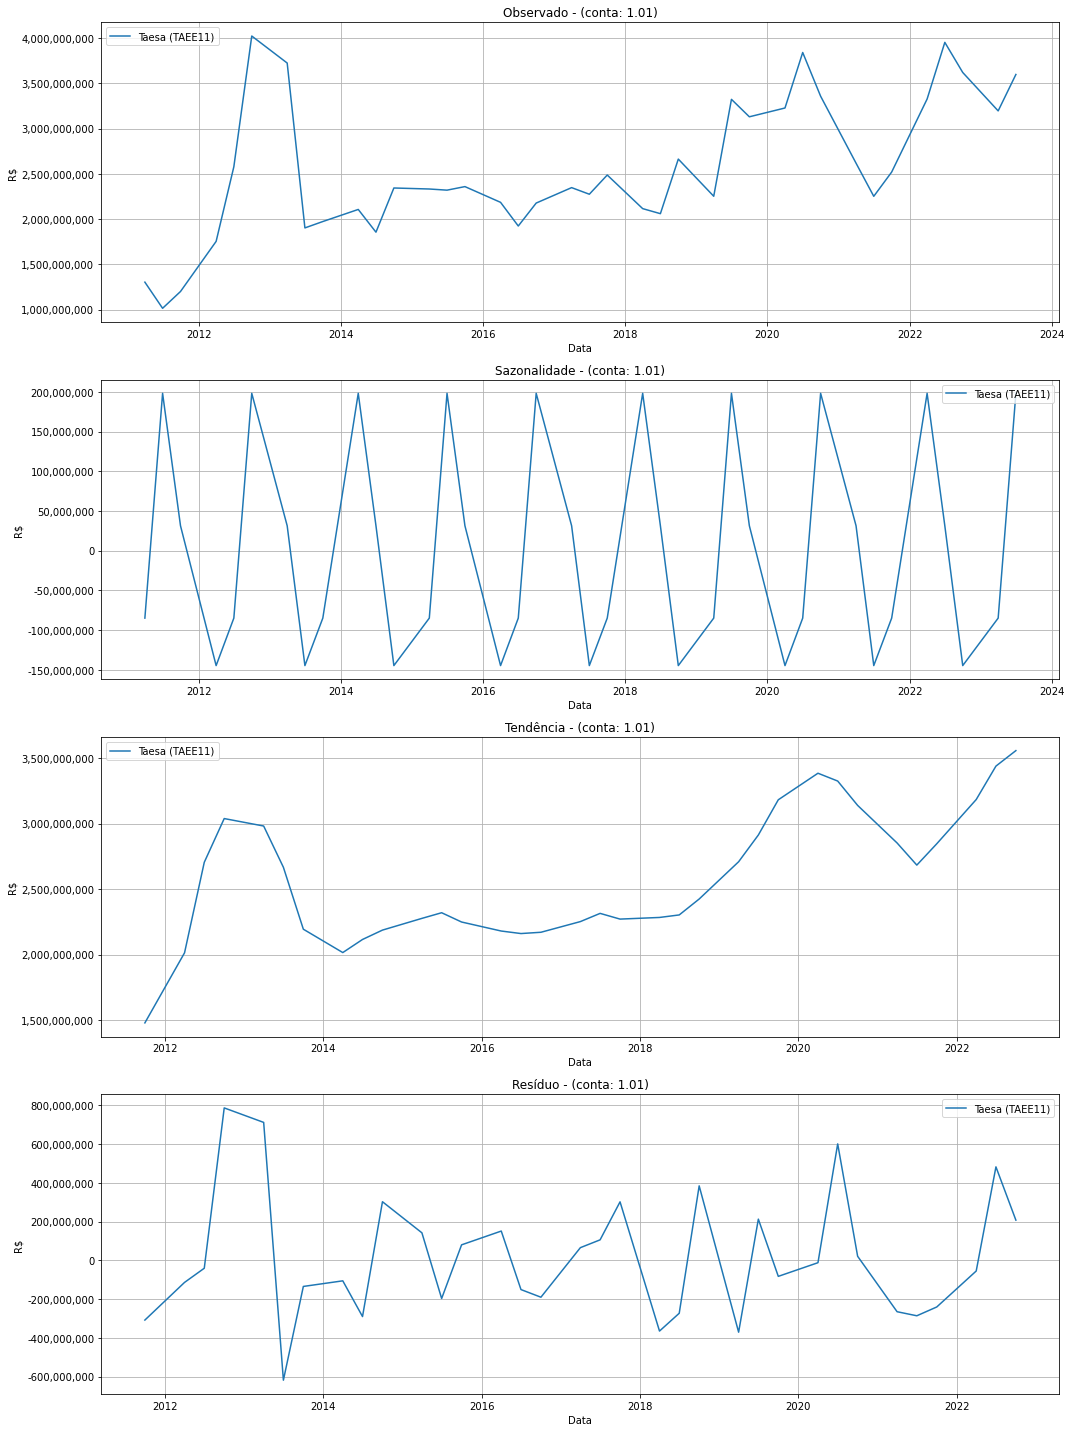


Checking if 1.01 is stationary
ADF Statistic: -2.5240617231860605
ADF p-value: 0.10972906644591796
Conclusion: The time series is NOT stationary

account
{'code': '1.01', 'stationary': False, 'diff_count': 0}




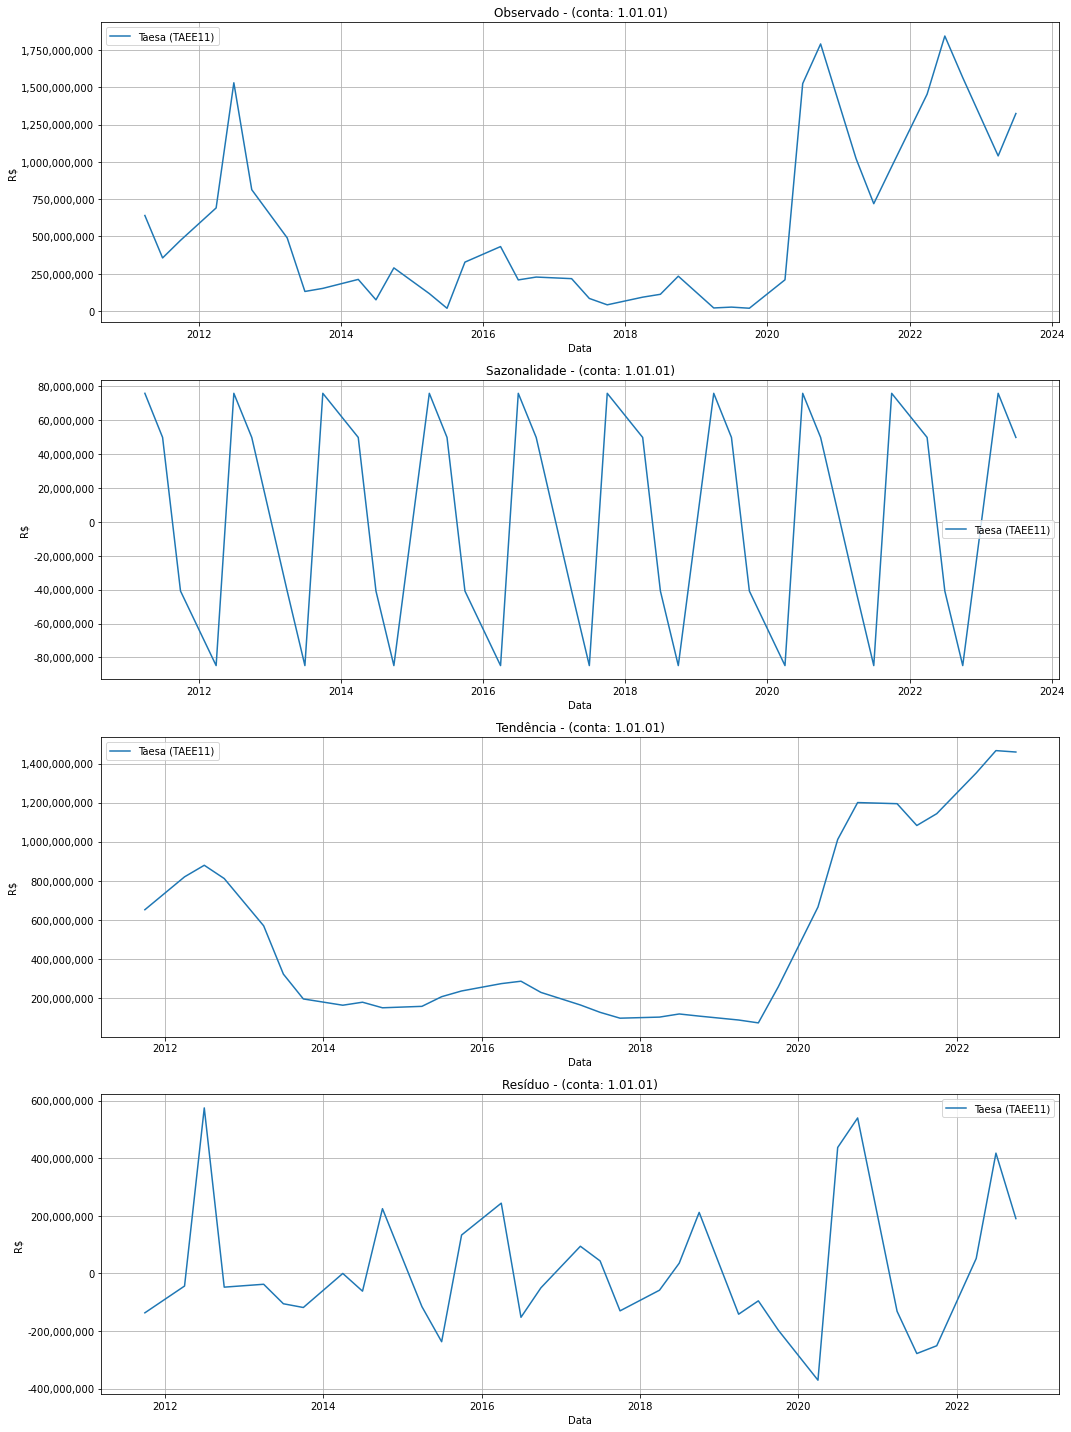


Checking if 1.01.01 is stationary
ADF Statistic: -0.44088820994314654
ADF p-value: 0.9030448295476938
Conclusion: The time series is NOT stationary

account
{'code': '1.01.01', 'stationary': False, 'diff_count': 0}




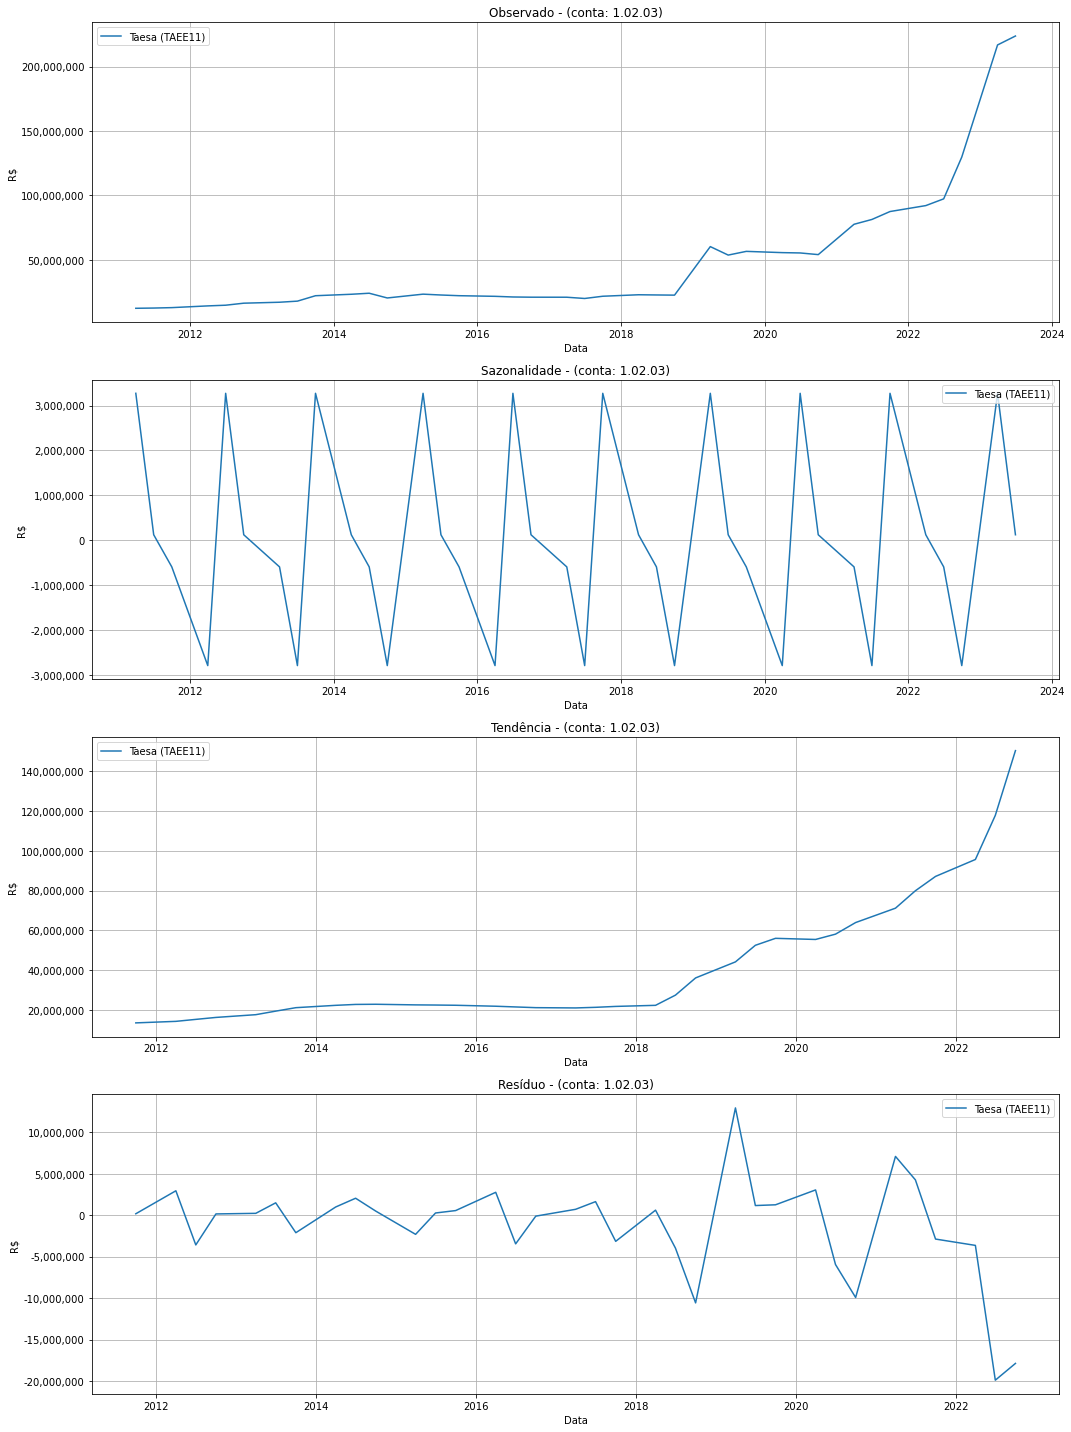


Checking if 1.02.03 is stationary
ADF Statistic: 3.7724502564448223
ADF p-value: 1.0
Conclusion: The time series is NOT stationary

account
{'code': '1.02.03', 'stationary': False, 'diff_count': 0}




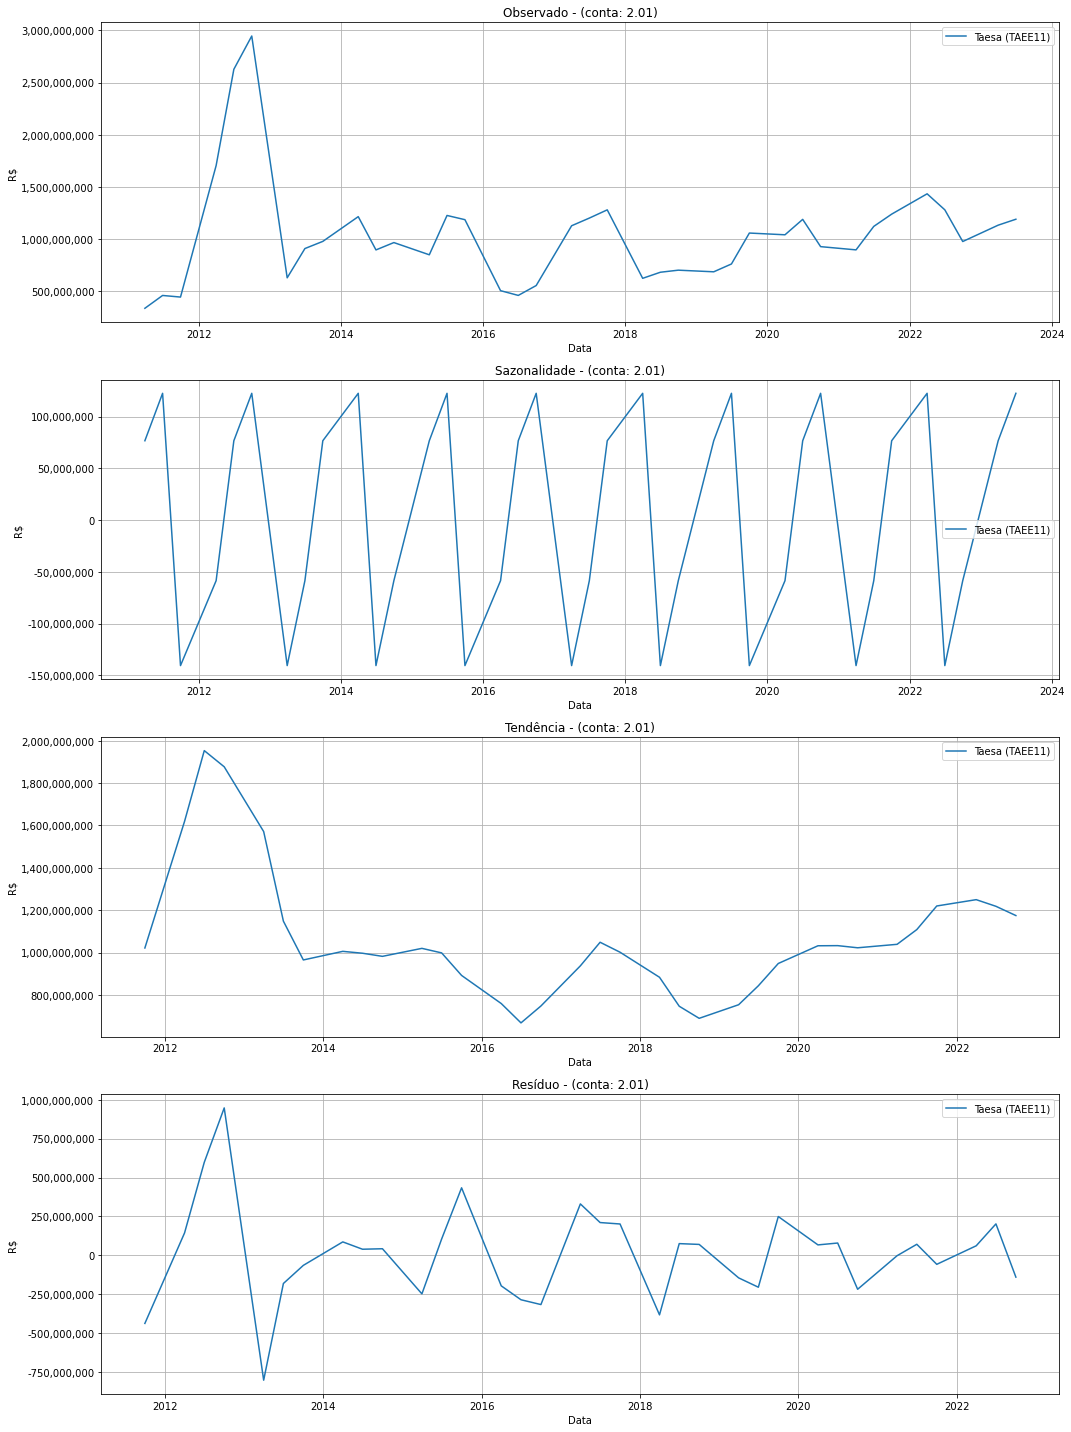


Checking if 2.01 is stationary
ADF Statistic: -2.101012922202895
ADF p-value: 0.2441074955129125
Conclusion: The time series is NOT stationary

account
{'code': '2.01', 'stationary': False, 'diff_count': 0}



Checking if 2.01.03 is stationary
ADF Statistic: -3.6745796985283388
ADF p-value: 0.004485258456553979
Conclusion: The time series is stationary

account
{'code': '2.01.03', 'stationary': True, 'diff_count': 0}



Checking if 2.01.04 is stationary
ADF Statistic: -2.796039411044252
ADF p-value: 0.058841740922901696
Conclusion: The time series is NOT stationary

account
{'code': '2.01.04', 'stationary': False, 'diff_count': 0}



Checking if 2.02.01 is stationary
ADF Statistic: 0.51626276779643
ADF p-value: 0.9853590975005982
Conclusion: The time series is NOT stationary

account
{'code': '2.02.01', 'stationary': False, 'diff_count': 0}



Checking if 3.11 is stationary
ADF Statistic: -2.9910162594886063
ADF p-value: 0.035741928590166214
Conclusion: The time series is stationary



In [37]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


# reading data
df = read_csv('pivot', index_col="DT_REFER")

def print_graph(size, index, data, company, title, account):
    plt.subplot(size, 1, index)
    plt.plot(data, label=f"{company['name']} ({company['ticker']})")
    plt.title(f"{title} - (conta: {account['code']})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)

def check_stationarity(data, code):
    print(f'\nChecking if {code} is stationary')
    # Performing the Augmented Dickey-Fuller test:
    adf_result = adfuller(data)
    adf_statistic, adf_p_value = adf_result[0], adf_result[1]
    print('ADF Statistic:', adf_statistic)
    print('ADF p-value:', adf_p_value)

    is_stationary = adf_p_value <= P_VALUE
    if is_stationary:
        print("Conclusion: The time series is stationary")
    else:
        print("Conclusion: The time series is NOT stationary")
    return is_stationary

def decompose_and_print(df, accounts):
    for company_code in companies:
        company_data = df[df['CD_CVM'] == company_code]
        company = companies[company_code]

        count = 0
        for account_key in accounts:
            count += 1
            account = accounts[account_key]

            # 4 = quarter division
            decomposition = seasonal_decompose(company_data[account_key], model='additive', period=4)

            if (count < 5):
                plt.figure(figsize=(15, 20))
                print_graph(4, 1, decomposition.observed, company, 'Observado', account)
                print_graph(4, 2, decomposition.seasonal, company, 'Sazonalidade', account)
                print_graph(4, 3, decomposition.trend, company, 'Tendência', account)
                print_graph(4, 4, decomposition.resid, company, 'Resíduo', account)
                plt.tight_layout()
                plt.grid(True)
                plt.show()

            account['stationary'] = check_stationarity(company_data[account_key], account['code'])

            print('\naccount')
            print(account)
            print('\n')


decompose_and_print(df, accounts_to_calculate_fcfe)


#### 5.1.2 Making non-stationary series stationary

In [38]:
accounts_to_calculate_fcfe

{'VL_CONTA_1.01': {'code': '1.01', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_1.01.01': {'code': '1.01.01', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_1.02.03': {'code': '1.02.03', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_2.01': {'code': '2.01', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_2.01.03': {'code': '2.01.03', 'stationary': True, 'diff_count': 0},
 'VL_CONTA_2.01.04': {'code': '2.01.04', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_2.02.01': {'code': '2.02.01', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_3.11': {'code': '3.11', 'stationary': True, 'diff_count': 0},
 'VL_CONTA_6.01': {'code': '6.01', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_6.02': {'code': '6.02', 'stationary': True, 'diff_count': 0},
 'VL_CONTA_6.03': {'code': '6.03', 'stationary': False, 'diff_count': 0},
 'VL_CONTA_7.04.01': {'code': '7.04.01', 'stationary': True, 'diff_count': 0},
 'VL_CONTA_PENULTIMO_1.01': {'code': '1.01',
  'stationary': False,
  'diff_coun


-----------------------------------------------------------------

company_code: 20257

..... ..... ..... ..... .....
account_key: VL_CONTA_1.01
account: {'code': '1.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '1.01', 'stationary': False, 'diff_count': 0}


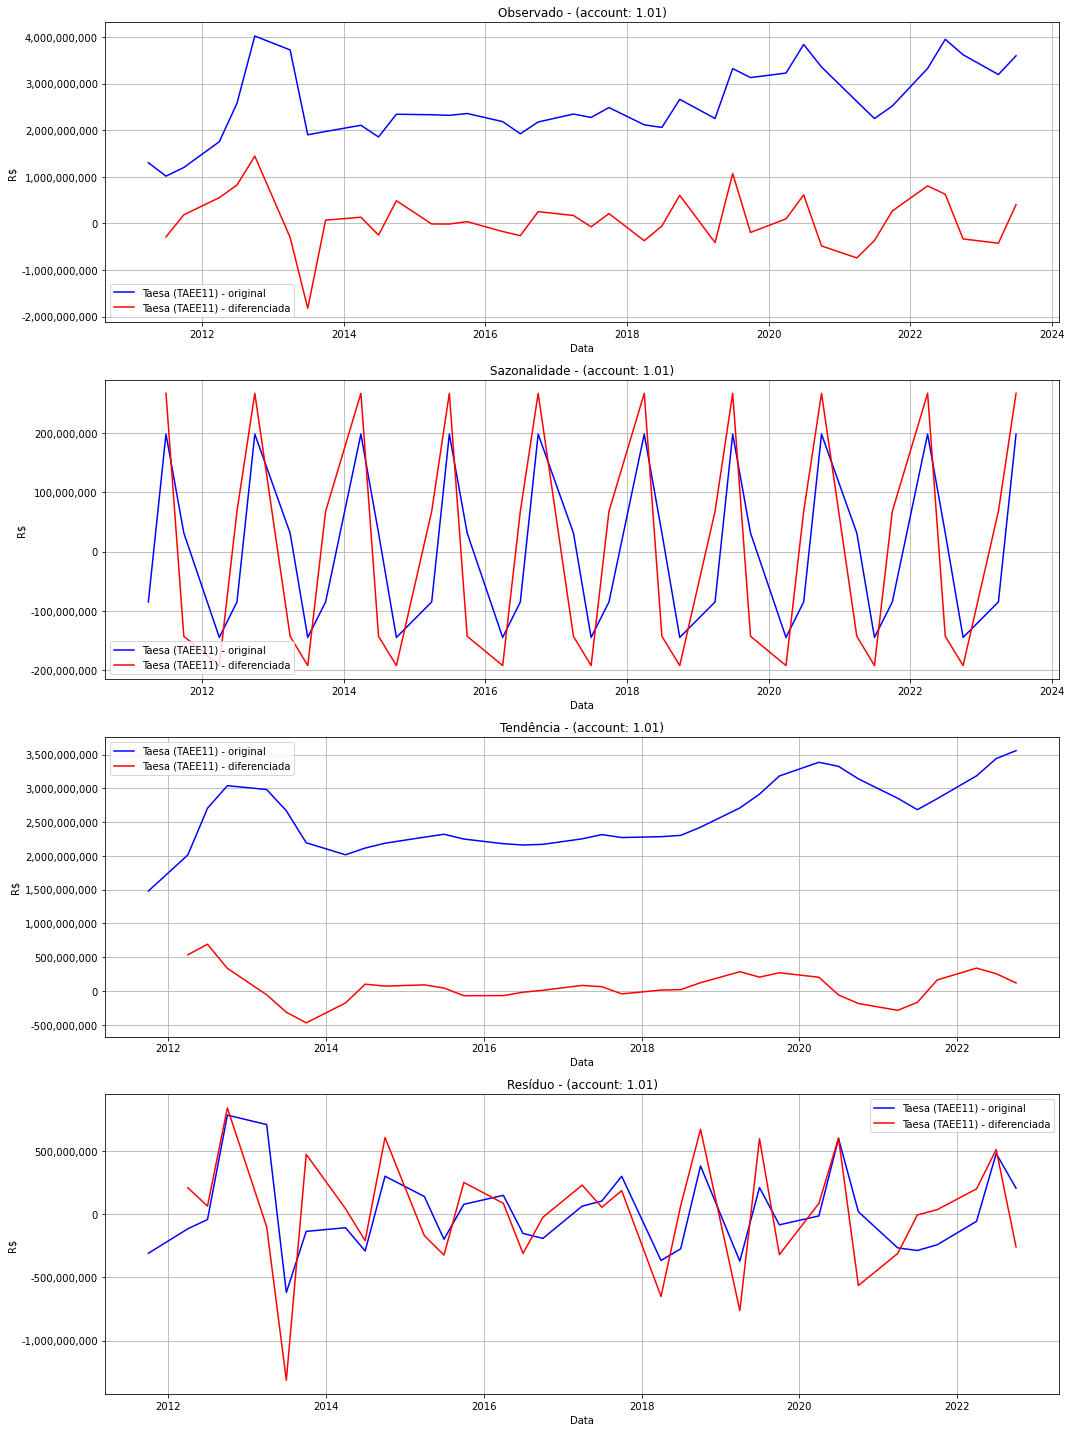


Checking if 1.01 is stationary
ADF Statistic: -5.306825035892374
ADF p-value: 5.300192743753107e-06
Conclusion: The time series is stationary

 after differentiation
{'code': '1.01', 'stationary': True, 'diff_count': 1}

..... ..... ..... ..... .....
account_key: VL_CONTA_1.01.01
account: {'code': '1.01.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '1.01.01', 'stationary': False, 'diff_count': 0}


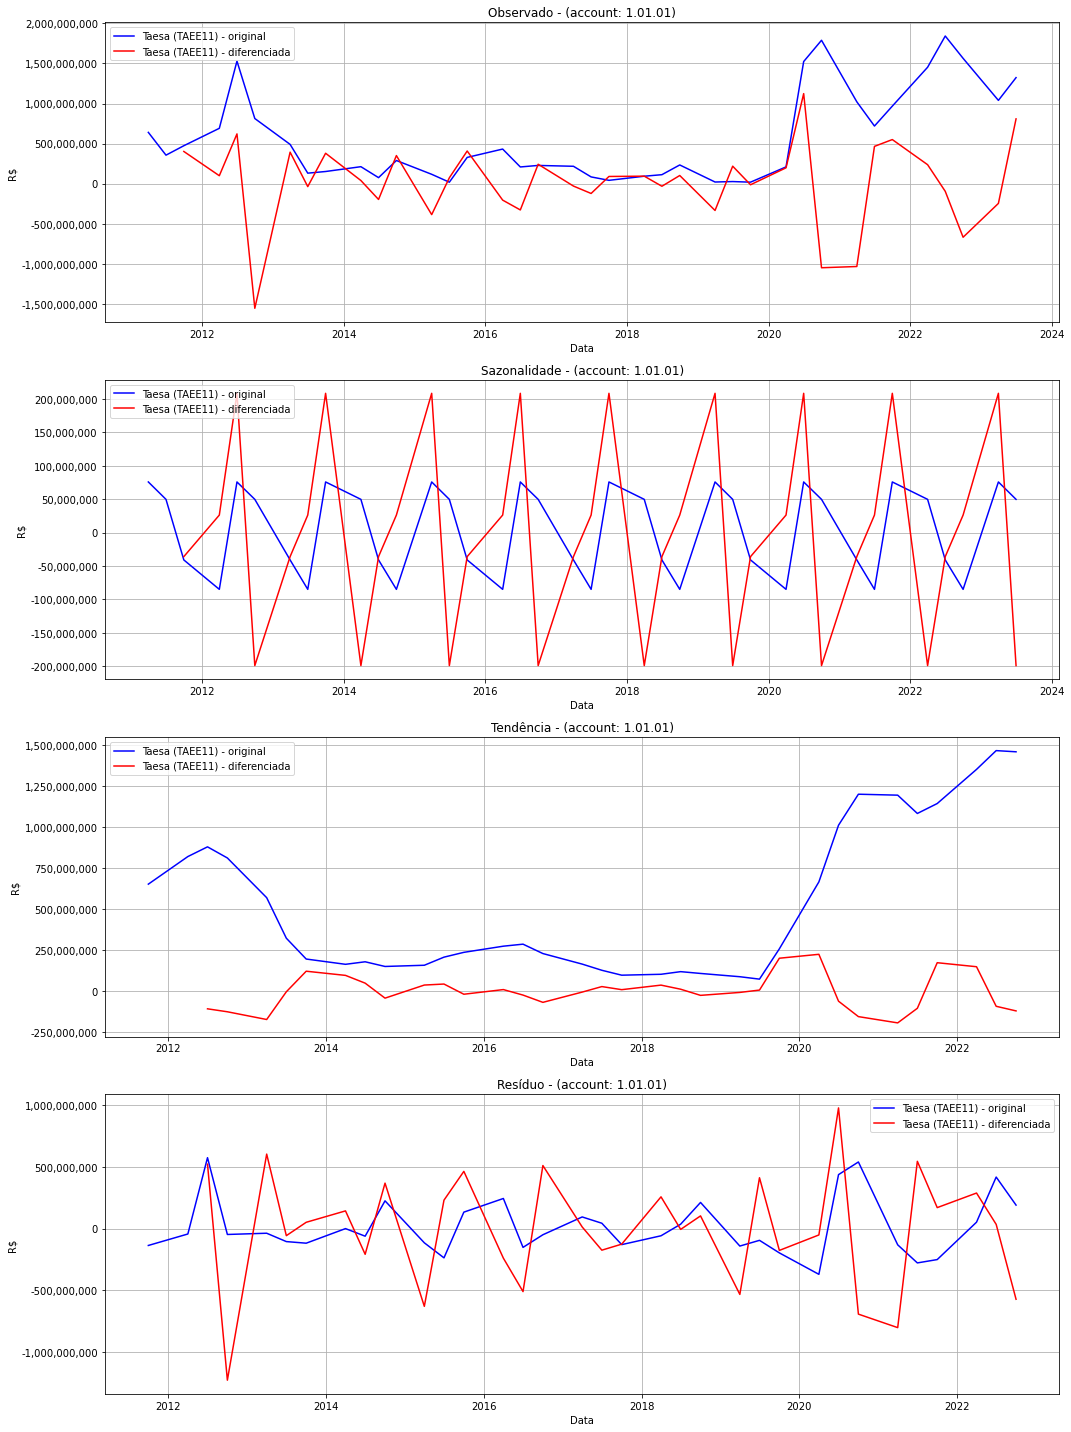


Checking if 1.01.01 is stationary
ADF Statistic: -6.862711375704869
ADF p-value: 1.5874270525949579e-09
Conclusion: The time series is stationary

 after differentiation
{'code': '1.01.01', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_1.02.03
account: {'code': '1.02.03', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '1.02.03', 'stationary': False, 'diff_count': 0}


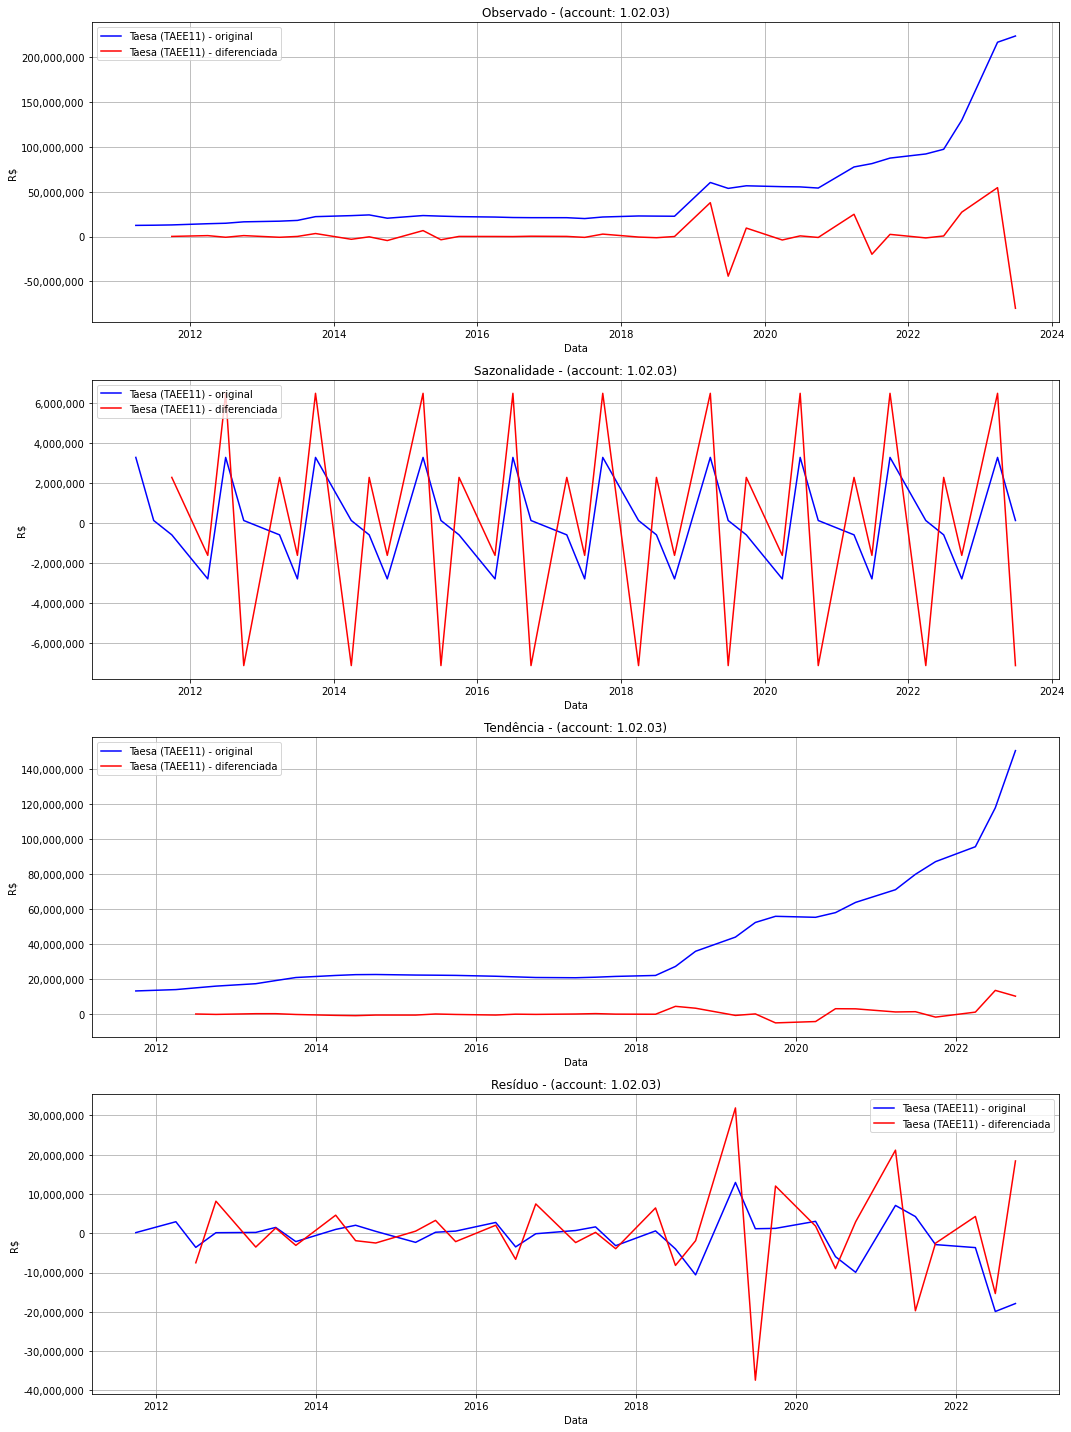


Checking if 1.02.03 is stationary
ADF Statistic: -3.11353793326558
ADF p-value: 0.02556740799758976
Conclusion: The time series is stationary

 after differentiation
{'code': '1.02.03', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.01
account: {'code': '2.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '2.01', 'stationary': False, 'diff_count': 0}


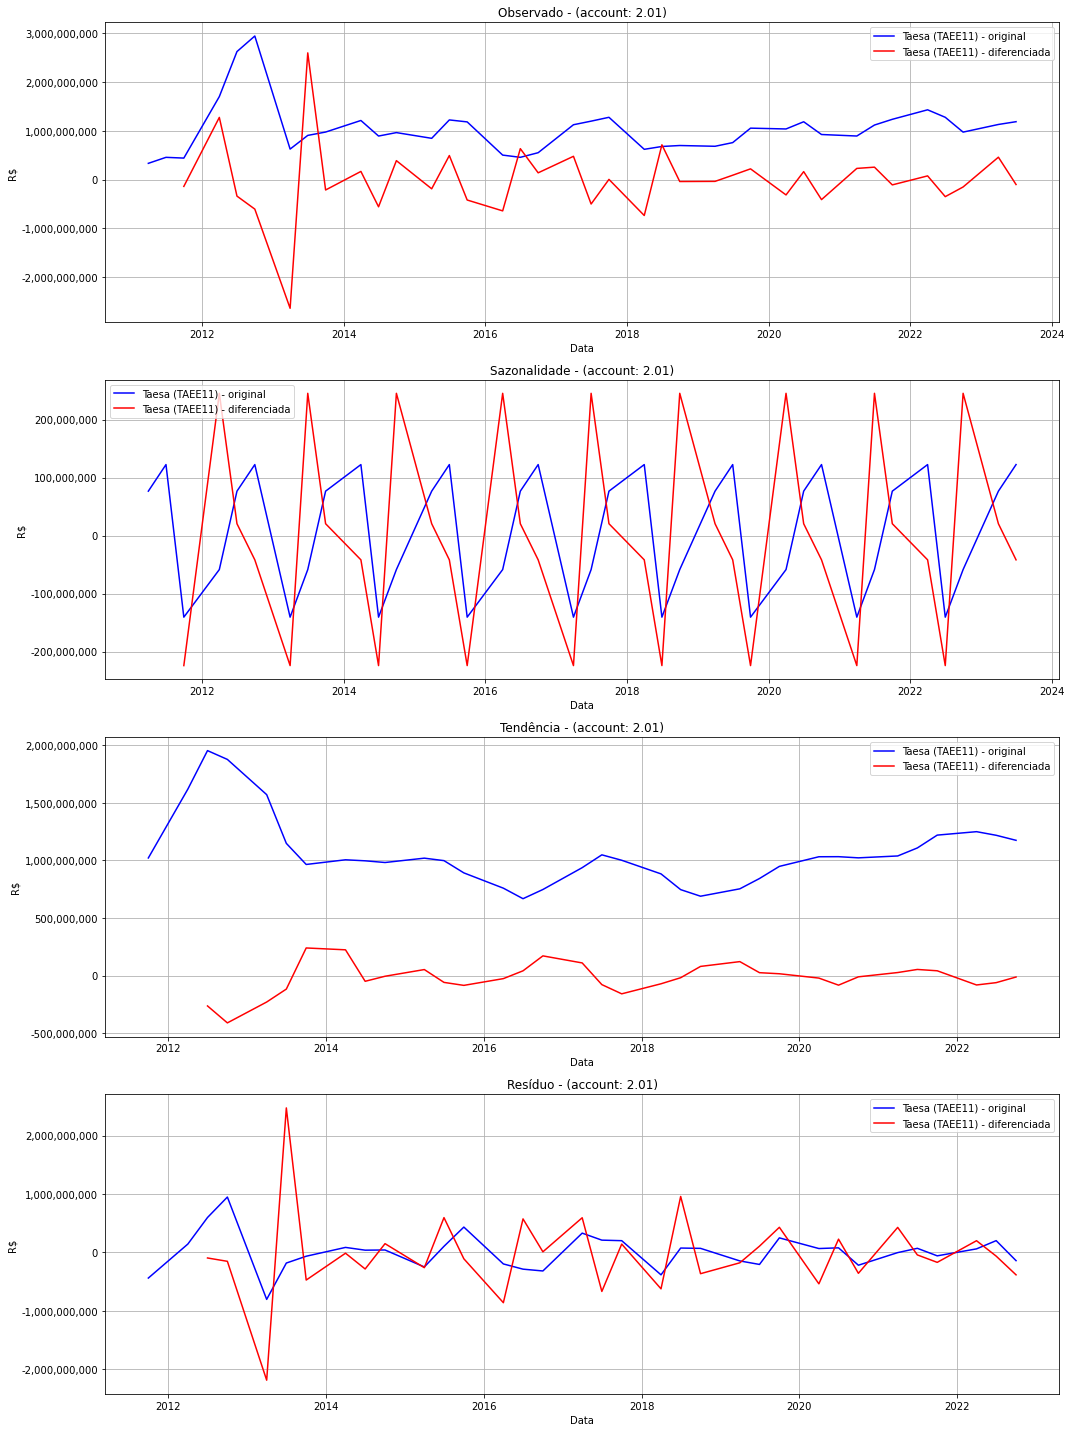


Checking if 2.01 is stationary
ADF Statistic: -7.776214418430882
ADF p-value: 8.655524099270813e-12
Conclusion: The time series is stationary

 after differentiation
{'code': '2.01', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.01.03
account: {'code': '2.01.03', 'stationary': True, 'diff_count': 0}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.01.04
account: {'code': '2.01.04', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '2.01.04', 'stationary': False, 'diff_count': 0}

Checking if 2.01.04 is stationary
ADF Statistic: -7.994044955722799
ADF p-value: 2.4310268925590994e-12
Conclusion: The time series is stationary

 after differentiation
{'code': '2.01.04', 'stationary': True, 'diff_count': 2}

..... ..... ..... ..... .....
account_key: VL_CONTA_2.02.01
account: {'code': '2.02.01', 'stationary': False, 'diff_count': 0}

 before differentiation
{'code': '2.02.01', 'stationary': False, 'diff_count': 0}

C

In [39]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series):
    result = adfuller(series)
    return result[1] <= P_VALUE

def make_series_stationary(series, account, max_diff=5):
    stationary_series = series.copy()
    for _ in range(max_diff):
        stationary_series = stationary_series.diff().dropna()
        # increment differentiations
        account['diff_count'] += 1
        if adfuller_test(stationary_series):
            return stationary_series
    return None

def print_graph(size, index, data_original, data, company, title, account):
    plt.subplot(size, 1, index)
    plt.plot(data_original, label=f"{company['name']} ({company['ticker']}) - original", color='blue')
    plt.plot(data, label=f"{company['name']} ({company['ticker']}) - diferenciada", color='red')
    plt.title(f"{title} - (account: {account['code']})")
    plt.xlabel('Data')
    plt.ylabel('R$')
    plt.legend(loc='best')
    plt.ticklabel_format(style='plain', axis='y')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.grid(True)

def make_series_stationary_and_print(df_original, df, accounts):
    df_updated = df.copy()  # Criamos uma cópia para trabalhar
    for company_code in companies:
        print('\n-----------------------------------------------------------------\n')
        print(f'company_code: {company_code}')

        company = companies[company_code]

        company_data_original = df_original[df_original['CD_CVM'] == company_code].copy()
        company_data = df_updated[df_updated['CD_CVM'] == company_code].copy()

        count = 0
        for account_key in accounts:
            count += 1
            print("\n..... ..... ..... ..... .....")
            account = accounts[account_key]
            print(f'account_key: {account_key}')
            print(f'account: {account}')

            if (not account['stationary']):
                account_data_original = company_data_original[account_key].copy()
                account_data = company_data[account_key].copy()

                # Making the series stationary
                print('\n before differentiation')
                print(account)
                account_data = make_series_stationary(account_data, account)
                decomposition_original = seasonal_decompose(account_data_original, model='additive', period=4)
                decomposition = seasonal_decompose(account_data, model='additive', period=4)

                if (count < 5):
                    plt.figure(figsize=(15, 20))
                    print_graph(4, 1, decomposition_original.observed, decomposition.observed, company, 'Observado', account)
                    print_graph(4, 2, decomposition_original.seasonal, decomposition.seasonal, company, 'Sazonalidade', account)
                    print_graph(4, 3, decomposition_original.trend, decomposition.trend, company, 'Tendência', account)
                    print_graph(4, 4, decomposition_original.resid, decomposition.resid, company, 'Resíduo', account)
                    plt.tight_layout()
                    plt.grid(True)
                    plt.show()

                account['stationary'] = check_stationarity(account_data, account['code'])
                company_data[account_key] = account_data

                print('\n after differentiation')
                print(account)

        df_updated.loc[df_updated['CD_CVM'] == company_code, :] = company_data

    return df_updated


df_result = df.copy()
df_result = make_series_stationary_and_print(df, df_result, accounts_to_calculate_fcfe)

print("\n----- ----- ----- ----- ----- ----- ----- ----- ----- -----")
print('df_stationary')
print(df_result)

print("\n----- ----- ----- ----- ----- ----- ----- ----- ----- -----")
print('accounts_to_calculate_fcfe')
print(accounts_to_calculate_fcfe)

saveToFile('stationary', df_result, setIndex=False)
saveToFile('stationary_drop_na', df_result.dropna(), setIndex=False)


### 5.2 Modeling


#### 5.2.0 Modeling common functions

In [40]:
import numpy as np

DATE_CUTOFF = '2023-01-01'
END_DATE = '2024-12-31'

# def mape(y_true, y_pred):
#     """
#     Calculate the Mean Absolute Percentage Error (MAPE).
    
#     Args:
#     - y_true: Array-like of true values.
#     - y_pred: Array-like of predicted values.
    
#     Returns:
#     - mape: Mean absolute percentage error.
#     """
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def calculating_MAPE(y_train, y_test, pred_train, pred_test):
#     print(f'\n-> Calculando o MAPE')

#     mape_train = mape(y_train, pred_train)
#     mape_train_accuracy = 100 - mape_train
#     print(f'mape_train: {mape_train}')
#     print(f'mape_train_accuracy: {mape_train_accuracy:.2f}%\n')

#     mape_test = mape(y_test, pred_test)
#     mape_test_accuracy = 100 - mape_test
#     print(f'mape_test: {mape_test}')
#     print(f'mape_test_accuracy: {mape_test_accuracy:.2f}%\n')
#     return mape_train,mape_train_accuracy,mape_test,mape_test_accuracy

def accuracy(y_true, y_pred):
    """
    Calculate the accuracy based on Mean Absolute Percentage Error (MAPE).
    
    Args:
    - y_true: Array-like of true values.
    - y_pred: Array-like of predicted values.
    
    Returns:
    - accuracy: Accuracy percentage.
    """
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return 100 - mape

def calculate_accuracy(y_train, y_test, pred_train, pred_test):
    """
    Calculate the accuracy for training and testing data.
    
    Args:
    - y_train: Array-like of training true values.
    - y_test: Array-like of testing true values.
    - pred_train: Array-like of training predicted values.
    - pred_test: Array-like of testing predicted values.
    
    Returns:
    - train_accuracy: Accuracy of the training predictions.
    - test_accuracy: Accuracy of the testing predictions.
    """
    train_accuracy = accuracy(y_train, pred_train)
    test_accuracy = accuracy(y_test, pred_test)
    
    print(f'\n-> Calculando a Acurácia')
    print(f'Acurácia de Treinamento: {train_accuracy:.2f}%')
    print(f'Acurácia de Teste: {test_accuracy:.2f}%\n')
    
    return train_accuracy, test_accuracy

def train_test_split(df, account):
    """
    Split the data into training and testing sets based on the DATE_CUTOFF.
    """
    print('\n-> Separating data in trainning and testing groups')
    train = df[df.index < DATE_CUTOFF]
    test = df[(df.index >= DATE_CUTOFF) & (df.index <= END_DATE)]

    X_train = train.drop(columns=[account, 'CD_CVM'])
    y_train = train[account]
    X_test = test.drop(columns=[account, 'CD_CVM'])
    y_test = test[account]

    y_train = y_train.dropna()
    X_train = X_train.loc[y_train.index]
    return train,test,X_train,y_train,X_test,y_test

def handle_missing_values(df):
    """
    Handle missing values in the DataFrame by forward and backward filling.
    
    Args:
    - df: Input DataFrame.
    
    Returns:
    - df: DataFrame with missing values handled.
    """
    return df.fillna(method='ffill').fillna(method='bfill')

# def plot_graph(algorithm, ax, idx, account, train, test, y_train, y_test, pred_train, pred_test, mape_train, mape_train_accuracy, mape_test, mape_test_accuracy):
#     """
#     Plot the real vs predicted values.
#     """
#     print(f'\n-> Plotting graph')
#     ax[idx].plot(train.index, y_train, label='Real Train')
#     ax[idx].plot(train.index, pred_train, label='Predicted Train')
#     ax[idx].plot(test.index, y_test, label='Real Test')
#     ax[idx].plot(test.index, pred_test, label='Predicted Test')
#     ax[idx].set_title(f'[[ {algorithm} ]]    {account} - MAPE Train: {mape_train:.2f}% | MAPE Test: {mape_test:.2f}% - Train Accuracy: {mape_train_accuracy:.2f}% | Test Accuracy: {mape_test_accuracy:.2f}%')
#     ax[idx].set_ylabel('R$')
#     ax[idx].legend(loc='best')
#     ax[idx].ticklabel_format(style='plain', axis='y')
#     ax[idx].yaxis.set_major_formatter(formatter)
#     ax[idx].grid(True)

def plot_graph(algorithm, ax, idx, account, y_train, y_test, pred_train, pred_test, train_accuracy, test_accuracy):
    """
    Plot the real vs predicted values.
    """
    print(f'\n-> Plotting graph')
    
    # Combining real and predicted values for a continuous plot
    combined_real = pd.concat([y_train, y_test])
    combined_pred = pd.concat([pd.Series(pred_train, index=y_train.index), pd.Series(pred_test, index=y_test.index)])

    ax[idx].plot(combined_real.index, combined_real, label='Real', color='blue')
    ax[idx].plot(combined_pred.index, combined_pred, linestyle='--', label='Predicted', color='red')
    
    ax[idx].set_title(f'[[ {algorithm} ]]  -  {account} | Train accuracy: {train_accuracy:.2f}% | Test accuracy: {test_accuracy:.2f}%')
    ax[idx].set_ylabel('R$')
    ax[idx].legend(loc='best')
    ax[idx].ticklabel_format(style='plain', axis='y')
    ax[idx].yaxis.set_major_formatter(formatter)
    ax[idx].grid(True)



#### 5.2.1 GLM


Training........................................
idx: 0
account: VL_CONTA_1.01

-> Separating data in trainning and testing groups

-> Selecting features with step-wise
Adicionando VL_CONTA_6.03 com p-value 6.0565e-05
Adicionando VL_CONTA_2.02.01 com p-value 0.000105329
Adicionando VL_CONTA_PENULTIMO_6.01 com p-value 0.00548677
Adicionando VL_CONTA_2.01 com p-value 0.00092017
Adicionando VL_CONTA_PENULTIMO_2.01.04 com p-value 0.00306217
Removendo VL_CONTA_2.02.01 com p-value 0.0943848
Adicionando VL_CONTA_PENULTIMO_1.01 com p-value 0.00143242

-> Trainning GLM model

-> Doing predictions

-> Calculando a Acurácia
Acurácia de Treinamento: -45.53%
Acurácia de Teste: 57.48%


-> Updating predictions into DataFrame

-> Plotting graph

Training........................................
idx: 1
account: VL_CONTA_1.01.01

-> Separating data in trainning and testing groups

-> Selecting features with step-wise
Adicionando VL_CONTA_PENULTIMO_1.02.03 com p-value 0.00104535

-> Trainning GLM model


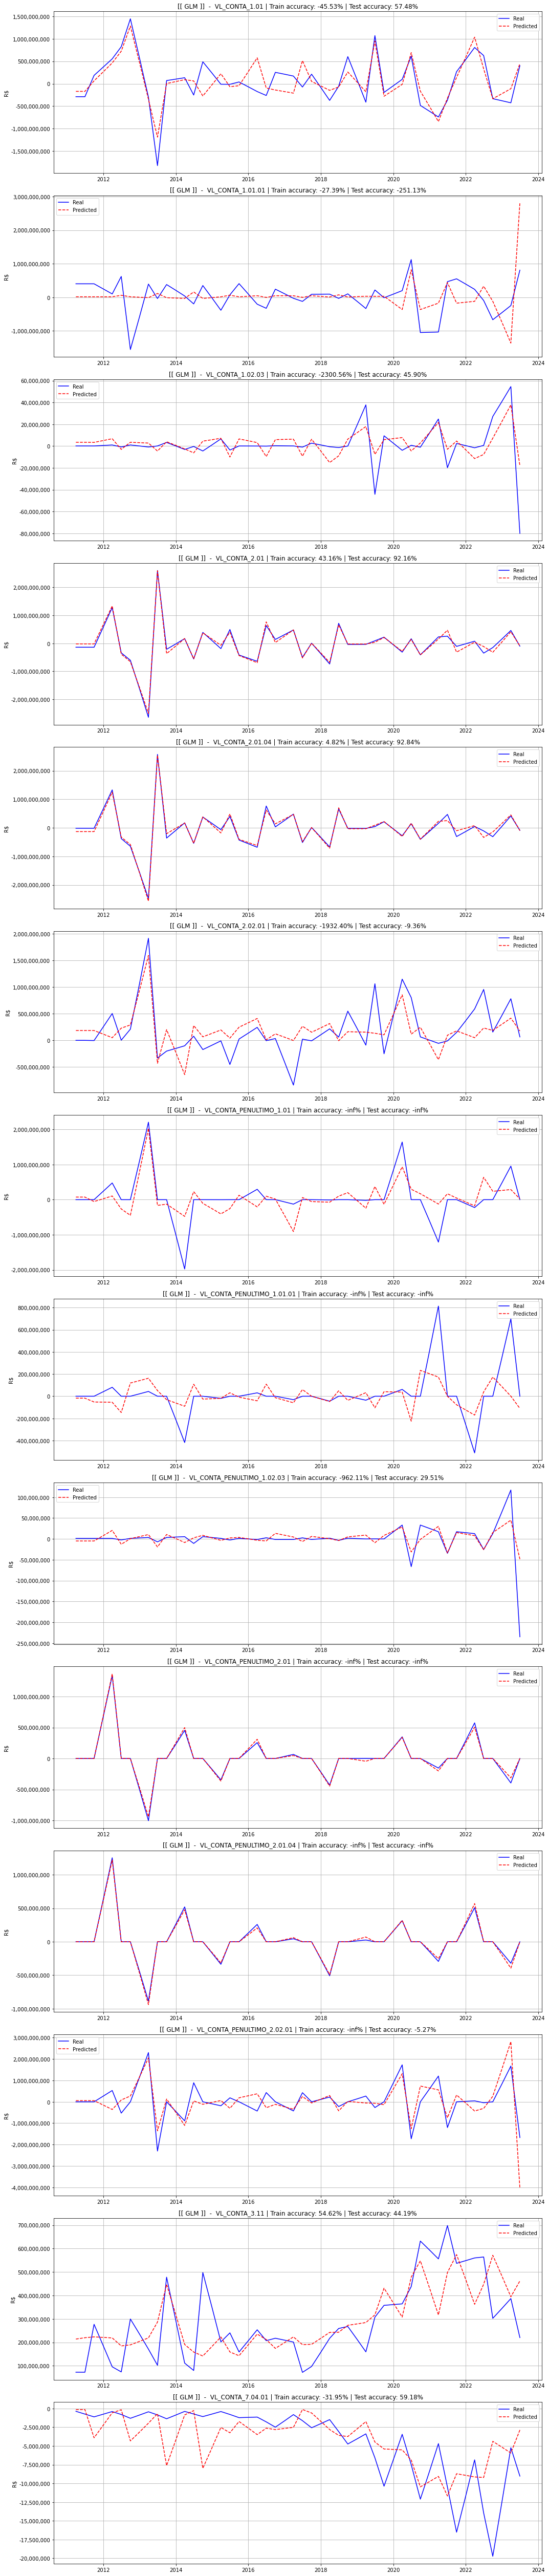


-----------------------------------------------------------------
saving file: df_glm.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2011-03-31 to 2023-06-30
Freq: Q-DEC
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CD_CVM                               50 non-null     float64
 1   VL_CONTA_1.01                        50 non-null     float64
 2   VL_CONTA_1.01.01                     50 non-null     float64
 3   VL_CONTA_1.02.03                     50 non-null     float64
 4   VL_CONTA_2.01                        50 non-null     float64
 5   VL_CONTA_2.01.03                     50 non-null     float64
 6   VL_CONTA_2.01.04                     50 non-null     float64
 7   VL_CONTA_2.02.01                     50 non-null     float64
 8   VL_CONTA_3.11                        50 non-null     float64
 9   VL_CONTA_6.01                

In [42]:
# GLM
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def stepwise_feature_selection(X, y, X_test, initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    """
    Stepwise feature selection based on p-values.
    
    Args:
    - X: DataFrame of predictor variables.
    - y: Series of response variable.
    - initial_list: List of initial features to include.
    - threshold_in: P-value threshold for feature inclusion.
    - threshold_out: P-value threshold for feature removal.
    - verbose: If True, prints progress messages.
    
    Returns:
    - included: List of selected features.
    """
    print(f'\n-> Selecting features with step-wise')
    included = list(initial_list)

    while True:
        changed = False

        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(dtype='float64', index=excluded)

        for new_column in excluded:
            model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Adicionando {best_feature} com p-value {best_pval:.6}')

        # backward step
        model = sm.GLM(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Removendo {worst_feature} com p-value {worst_pval:.6}')
        if not changed:
            break

    X = X[included]
    X_test = X_test[included]
    return X, X_test

def train_glm(X_train, y_train):
    """
    Train the Generalized Linear Model (GLM).
    """
    print(f'\n-> Trainning GLM model')
    model = sm.GLM(y_train, sm.add_constant(X_train)).fit()
    return model

def make_predictions(X_train, X_test, model):
    """
    Make predictions using the trained model.
    """
    print(f'\n-> Doing predictions')
    pred_train = model.predict(sm.add_constant(X_train))
    pred_test = model.predict(sm.add_constant(X_test))
    return pred_train,pred_test

def update_predictions(results_df, account, train, test, pred_train, pred_test):
    print(f'\n-> Updating predictions into DataFrame')
    results_df.loc[train.index, f'{account}_pred_glm'] = pred_train
    results_df.loc[test.index, f'{account}_pred_glm'] = pred_test

def train_forecast_account(df, results_df, ax, idx, account):
    """
    Train the forecasting model for a specific account and visualize the results.
    """
    print(f'\nTraining........................................')
    print(f'idx: {idx}')
    print(f'account: {account}')

    train, test, X_train, y_train, X_test, y_test = train_test_split(df, account)

    X_train, X_test = stepwise_feature_selection(X_train, y_train, X_test)

    model = train_glm(X_train, y_train)

    pred_train, pred_test = make_predictions(X_train, X_test, model)

    train_accuracy, test_accuracy = calculate_accuracy(y_train, y_test, pred_train, pred_test)

    update_predictions(results_df, account, train, test, pred_train, pred_test)

    plot_graph('GLM', ax, idx, account, y_train, y_test, pred_train, pred_test, train_accuracy, test_accuracy)

if __name__ == "__main__":
    # Load and preprocess data
    df = read_csv('stationary', index_col='DT_REFER', frequency='Q', interpolate=True)
    df = handle_missing_values(df)
    results_df = df.copy()

    # Train and visualize
    fig, ax = plt.subplots(len(columns_to_forecast), 1, figsize=(15, 5 * len(columns_to_forecast)))
    for idx, account in enumerate(columns_to_forecast):
        train_forecast_account(df, results_df, ax, idx, account)
    plt.tight_layout()
    plt.show()

saveToFile('glm', results_df, setIndex=False)

#### 5.2.2 ARIMAX


Training........................................
idx: 0
account: VL_CONTA_1.01

-> Separating data in trainning and testing groups

-> Training ARIMAX model with starting differencing order 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=258839.437, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=144923.254, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=334540.197, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=144699.954, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=144959.483, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=258998.866, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=144528.476, Time=2.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=258872.499, Time=1.76 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=144388.058, Time=2.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=258745.633, Time=2.69 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=144268.584, Time=2.87 sec
 ARIMA(1,1,4)(0,

/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/home/enok/.local/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/home/enok/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=4.48 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=8.03 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 68.551 seconds

-> Doing predictions

-> Calculando a Acurácia
Acurácia de Treinamento: 99.92%
Acurácia de Teste: 59.45%


-> Updating predictions into DataFrame

-> Plotting graph


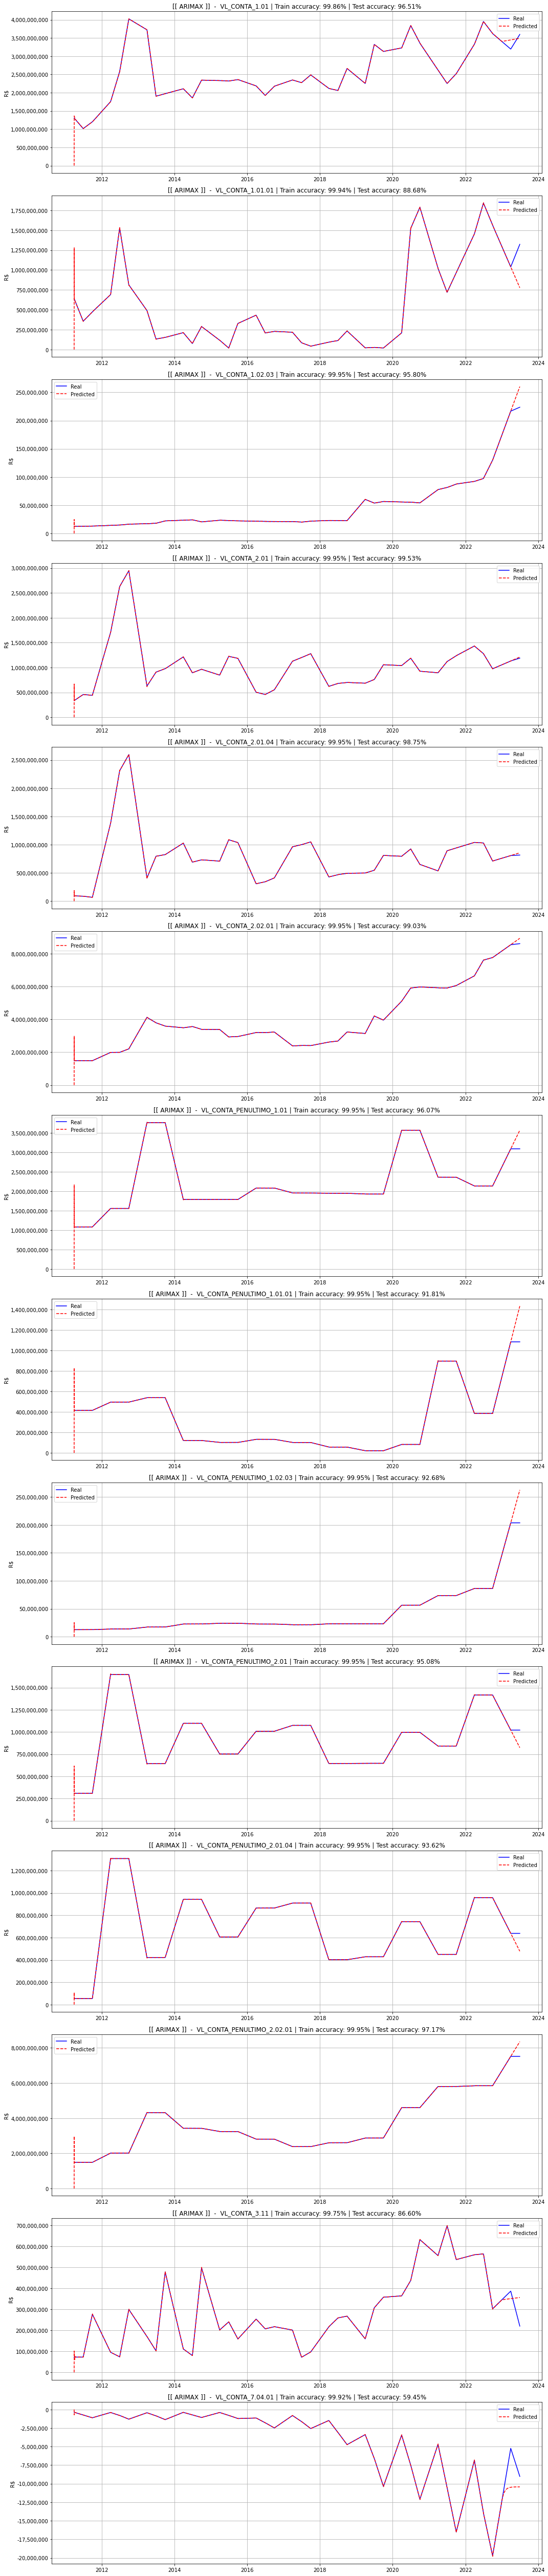


-----------------------------------------------------------------
saving file: df_arimax.csv


df.info():

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4475 entries, 2011-03-31 to 2023-06-30
Freq: D
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CD_CVM                                 4475 non-null   float64
 1   VL_CONTA_1.01                          4475 non-null   float64
 2   VL_CONTA_1.01.01                       4475 non-null   float64
 3   VL_CONTA_1.02.03                       4475 non-null   float64
 4   VL_CONTA_2.01                          4475 non-null   float64
 5   VL_CONTA_2.01.03                       4475 non-null   float64
 6   VL_CONTA_2.01.04                       4475 non-null   float64
 7   VL_CONTA_2.02.01                       4475 non-null   float64
 8   VL_CONTA_3.11                          4475 non-null   float64
 9   VL_CON

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima

def train_arimax(X_train, y_train, start_diff):
    """
    Train the ARIMAX model using auto_arima.
    """
    print(f'\n-> Training ARIMAX model with starting differencing order {start_diff}')
    #model = auto_arima(y_train, exogenous=X_train, start_d=start_diff, seasonal=False, trace=True, stepwise=True)
    model = auto_arima(y_train, exogenous=X_train, seasonal=False, trace=True, stepwise=True)
    model_fit = model.fit(y_train, exogenous=X_train)
    return model_fit

def make_predictions(model_fit, X_train, X_test, n_forecast):
    """
    Make predictions using the trained ARIMAX model.
    """
    print(f'\n-> Doing predictions')
    pred_train = model_fit.predict_in_sample(exogenous=X_train)
    pred_test = model_fit.predict(n_periods=n_forecast, exogenous=X_test)
    return pred_train, pred_test

def update_predictions(results_df, account, train, test, pred_train, pred_test):
    print(f'\n-> Updating predictions into DataFrame')
    results_df.loc[train.index, f'{account}_pred_arimax'] = pred_train
    results_df.loc[test.index, f'{account}_pred_arimax'] = pred_test

def train_forecast_account(df, results_df, ax, idx, account):
    """
    Train the forecasting model for a specific account and visualize the results.
    """
    print(f'\nTraining........................................')
    print(f'idx: {idx}')
    print(f'account: {account}')

    train, test, X_train, y_train, X_test, y_test = train_test_split(df, account)
    start_diff = accounts_to_calculate_fcfe[account]["diff_count"]
    
    model_fit = train_arimax(X_train, y_train, start_diff)

    pred_train, pred_test = make_predictions(model_fit, X_train, X_test, len(y_test))

    train_accuracy, test_accuracy = calculate_accuracy(y_train, y_test, pred_train, pred_test)

    update_predictions(results_df, account, train, test, pred_train, pred_test)

    plot_graph('ARIMAX', ax, idx, account, y_train, y_test, pred_train, pred_test, train_accuracy, test_accuracy)

if __name__ == "__main__":
    # Load and preprocess data
    df = read_csv('pivot', index_col='DT_REFER', frequency='D', interpolate=True)
    df = handle_missing_values(df)
    results_df = df.copy()

    # Train and visualize
    fig, ax = plt.subplots(len(columns_to_forecast), 1, figsize=(15, 5 * len(columns_to_forecast)))
    for idx, account in enumerate(columns_to_forecast):
        train_forecast_account(df, results_df, ax, idx, account)
    plt.tight_layout()
    plt.show()

saveToFile('arimax', results_df, setIndex=False)

In [44]:
# # ARIMA
# import numpy as np
# import pandas as pd
# import pmdarima as pm
# import matplotlib.pyplot as plt
# from pandas.tseries.offsets import DateOffset

# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# group_of_months = 4
# frequency = 'D' 

# #df_pivot = pd.read_csv('./df_stationary.csv', sep=';', parse_dates=True, index_col='DT_REFER').asfreq('D').interpolate(method='linear')
# df_pivot = pd.read_csv('./df_stationary.csv', sep=';', parse_dates=True, index_col='DT_REFER')

# for company_code in companies:
#     company = companies[company_code]
#     company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
#     # Split data
#     split_ratio = 0.9
#     train_size = int(len(company_data) * split_ratio)
#     train = company_data['FCFE'].iloc[:train_size]
#     test = company_data['FCFE'].iloc[train_size:]

#     model = pm.auto_arima(train,
#                           seasonal=True, m=group_of_months,
#                           d=0, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
#                           trace=True, error_action='ignore', suppress_warnings=True)

#     end_date = pd.to_datetime('2024-12-31')
#     n_forecast_test = len(test)
#     n_forecast_future = (end_date - train.index[-1]).days + 1
#     n_forecast_total = n_forecast_test + n_forecast_future

#     forecast_index = pd.date_range(start=train.index[-1] + DateOffset(days=1), periods=n_forecast_total, freq=frequency)
#     predicted = model.predict(n_periods=n_forecast_total)
#     predicted_series = pd.Series(predicted, index=forecast_index)

#     if predicted_series.isnull().any():
#         print("Tentando um modelo mais simples...")
#         model = pm.ARIMA(order=(1, 0, 1))
#         model.fit(train)
#         predicted = model.predict(n_periods=n_forecast_total)
#         predicted_series = pd.Series(predicted, index=forecast_index)

#     mape = mean_absolute_percentage_error(test, predicted[:n_forecast_test])
#     accuracy = 100 - mape
#     print(f"\nMAPE: {mape:.2f}%")
#     print(f"Accuracy: {accuracy:.2f}%\n")

#     plt.figure(figsize=(15, 5))
#     plt.plot(company_data.index, company_data['FCFE'], label=f"FCFE Histórico")
#     plt.plot(predicted_series.index, predicted_series, color='red', label='FCFE Predição')
#     plt.ylim(min(min(company_data['FCFE']), min(predicted_series)), max(max(company_data['FCFE']), max(predicted_series)))
#     plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']}) - Acurácia: {accuracy:.2f}%")
#     plt.xlabel('Data')
#     plt.ylabel('Fluxo de Caixa Livre')
#     plt.legend(loc='best')
#     plt.ticklabel_format(style='plain', axis='y')
#     ax = plt.gca()
#     ax.yaxis.set_major_formatter(formatter)
#     plt.grid(True)
#     plt.show()


#### 5.2.3 ARIMA - with exogenous variables (multivariable)

In [45]:
# # ARIMA - with exogenous variables (multivariable)
# import numpy as np
# import pandas as pd
# import pmdarima as pm
# import matplotlib.pyplot as plt
# from pandas.tseries.offsets import DateOffset

# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# # def remove_low_correlation_columns(df, threshold=0.5):
# #     correlations = df.corrwith(df['FCFE'])
# #     low_corr_columns = correlations[correlations.abs() < threshold].index.tolist()
# #     return df.drop(columns=low_corr_columns)

# group_of_months = 4
# months = 3
# frequency = 'D' 

# # Read the data
# df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

# for company_code in companies:
#     company = companies[company_code]
#     company_data = df_pivot[df_pivot['CD_CVM'] == company_code]
    
#     # Remove columns with low correlation
#     # company_data = remove_low_correlation_columns(company_data)
    
#     # Split data
#     split_ratio = 0.9
#     train_size = int(len(company_data) * split_ratio)
#     train = company_data.iloc[:train_size]
#     test = company_data.iloc[train_size:]
#     exog_train = train.drop(columns=['FCFE', 'CD_CVM'])

#     assert not exog_train.isnull().any().any(), "Existem NaNs em exog_train"

#     model = pm.auto_arima(train['FCFE'],
#                           exogenous=exog_train,
#                           seasonal=True, m=group_of_months,
#                           d=0, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
#                           trace=True, error_action='ignore', suppress_warnings=True)

#     end_date = pd.to_datetime('2024-12-31')
#     n_forecast_test = len(test)
#     n_forecast_future = (end_date - train.index[-1]).days + 1
#     n_forecast_total = n_forecast_test + n_forecast_future
    
#     forecast_index = pd.date_range(start=train.index[-1] + DateOffset(days=1), periods=n_forecast_total, freq=frequency)
#     exog_forecast = pd.DataFrame([exog_train.iloc[-1]] * n_forecast_total, columns=exog_train.columns, index=forecast_index)

#     predicted = model.predict(n_periods=n_forecast_total, exogenous=exog_forecast)
#     predicted_series = pd.Series(predicted, index=forecast_index)

#     if predicted_series.isnull().any():
#         print("Tentando um modelo mais simples...")
#         model = pm.ARIMA(order=(1, 0, 1))
#         model.fit(train['FCFE'], exogenous=exog_train)
#         predicted = model.predict(n_periods=n_forecast_total, exogenous=exog_forecast)
#         predicted_series = pd.Series(predicted, index=forecast_index)

#     mape = mean_absolute_percentage_error(test['FCFE'], predicted[:n_forecast_test])
#     accuracy = 100 - mape
#     print(f"\nMAPE: {mape:.2f}%")
#     print(f"Accuracy: {accuracy:.2f}%\n")

#     plt.figure(figsize=(15, 5))
#     plt.plot(company_data.index, company_data['FCFE'], label=f"FCFE Histórico")
#     plt.plot(predicted_series.index, predicted_series, color='red', label='FCFE Predição')
#     plt.ylim(min(min(company_data['FCFE']), min(predicted_series)), max(max(company_data['FCFE']), max(predicted_series)))
#     plt.title(f"FCFE: Histórico vs Predição - {company['name']} ({company['ticker']}) - Acurácia: {accuracy:.2f}%")
#     plt.xlabel('Data')
#     plt.ylabel('Fluxo de Caixa Livre')
#     plt.legend(loc='best')
#     plt.ticklabel_format(style='plain', axis='y')
#     ax = plt.gca()
#     ax.yaxis.set_major_formatter(formatter)
#     plt.grid(True)
#     plt.show()


### 5.3 Free Cash Flow formula

*FCFE = <br>
  3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE)<br>
  \- (Δ 1.02.03 (Imobilizado) - 7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA))<br>
  \- (Δ 1.01 (Ativo Circulante) - Δ 1.01.01 (Caixa e Equivalentes de Caixa) -  Δ 2.01 (Passivo Circulante))<br>
  \+ (Δ 2.01.04(Emprestimos e Financiamentos Circulantes) + Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes))*<br><br>


*3.11 (Lucro/Prejuizo Consolidado do Periodo do DRE) = <br>
  LUCRO_LIQUIDO_PERIODO*<br>


*Δ 1.02.03 (Imobilizado) = <br>
  IMOBILIZADO_NO_PERIODO_ANTERIOR - IMOBILIZADO_NO_PERIODO*<br>


*7.04.01 (Depreciacao, Amortizacao e Exaustao da DVA) = <br>
  DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA*<br>


*Δ 1.01 (Ativo Circulante) = <br>
  ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - ATIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 1.01.01 (Caixa e Equivalentes de Caixa) = <br>
  CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR - CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO*<br>


*Δ 2.01 (Passivo Circulante) = <br>
  PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR - PASSIVO_CIRCULANTE_NO_PERIODO*<br>


*Δ 2.01.04(Emprestimos e Financiamentos Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO*<br>


*Δ 2.02.01(Emprestimos e Financiamentos Nao Circulantes) = <br>
  EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR - EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO*<br>

#### 5.3.1 Calculate FCFE value

In [46]:
####################################################################
# Lucro/Prejuizo Consolidado do Periodo do DRE (3.11)
####################################################################
df['LUCRO_LIQUIDO_PERIODO'] = df['VL_CONTA_3.11']


####################################################################
# Δ Imobilizado (1.02.03)
####################################################################
df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.02.03']
df['IMOBILIZADO_NO_PERIODO'] = df['VL_CONTA_1.02.03']
df['DELTA_IMOBILIZADO'] = df['IMOBILIZADO_NO_PERIODO_ANTERIOR'] - df['IMOBILIZADO_NO_PERIODO']


####################################################################
# Depreciacao, Amortizacao e Exaustao da DVA (7.04.01)
####################################################################
df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] = df['VL_CONTA_7.04.01']


####################################################################
# Δ Ativo Circulante (1.01)
####################################################################
df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.01']
df['ATIVO_CIRCULANTE_NO_PERIODO'] = df['VL_CONTA_1.01']
df['DELTA_ATIVO_CIRCULANTE'] = df['ATIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df['ATIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Caixa e Equivalentes de Caixa (1.01.01)
####################################################################
df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_1.01.01']
df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO'] = df['VL_CONTA_1.01.01']
df['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] = df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO_ANTERIOR'] - df['CAIXA_E_EQUIVALENTES_DE_CAIXA_NO_PERIODO']


####################################################################
# Δ Passivo Circulante (2.01)
####################################################################
df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.01']
df['PASSIVO_CIRCULANTE_NO_PERIODO'] = df['VL_CONTA_2.01']
df['DELTA_PASSIVO_CIRCULANTE'] = df['PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR'] - df['PASSIVO_CIRCULANTE_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Circulantes (2.01.04)
####################################################################
df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.01.04']
df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO'] = df['VL_CONTA_2.01.04']
df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] = df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df['EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO']


####################################################################
# Δ Emprestimos e Financiamentos Nao Circulantes (2.02.01)
####################################################################
df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] = df['VL_CONTA_PENULTIMO_2.02.01']
df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO'] = df['VL_CONTA_2.02.01']
df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'] = df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR'] - df['EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO']


# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
#
# Fluxo de Caixa Livre para os Acionistas (Free Cash Flows to Equity) - FCFE
#
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
df['FCFE'] = \
    df['LUCRO_LIQUIDO_PERIODO'] \
    - ( df['DELTA_IMOBILIZADO'] - df['DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA'] ) \
    - ( df['DELTA_ATIVO_CIRCULANTE'] - df['DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA'] - df['DELTA_PASSIVO_CIRCULANTE'] ) \
    + ( df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES'] + df['DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES'])

df.head()


,CD_CVM,VL_CONTA_1.01,VL_CONTA_1.01.01,VL_CONTA_1.02.03,VL_CONTA_2.01,VL_CONTA_2.01.03,VL_CONTA_2.01.04,VL_CONTA_2.02.01,VL_CONTA_3.11,VL_CONTA_6.01,...,PASSIVO_CIRCULANTE_NO_PERIODO_ANTERIOR,PASSIVO_CIRCULANTE_NO_PERIODO,DELTA_PASSIVO_CIRCULANTE,EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO_ANTERIOR,EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES_NO_PERIODO,DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES,EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO_ANTERIOR,EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES_NO_PERIODO,DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES,FCFE
DT_REFER,,,,,,,,,,,,,,,,,,,,,
2011-03-31,20257.0,1.304282e+09,6.404360e+08,1.243800e+07,3.347010e+08,7.513000e+06,9.476200e+07,1.487541e+09,7.283400e+07,1.732120e+08,...,308216000.0,3.347010e+08,-2.648500e+07,54017000.0,9.476200e+07,-4.074500e+07,1.487279e+09,1.487541e+09,-262000.000000,1.694000e+06
2011-04-01,20257.0,1.301109e+09,6.373105e+08,1.244002e+07,3.360532e+08,7.481868e+06,9.469509e+07,1.487547e+09,7.283303e+07,1.752337e+08,...,308216000.0,3.360532e+08,-2.783718e+07,54017000.0,9.469509e+07,-4.067809e+07,1.487279e+09,1.487547e+09,-267615.384615,3.522527e+05
2011-04-02,20257.0,1.297935e+09,6.341849e+08,1.244204e+07,3.374054e+08,7.450736e+06,9.462818e+07,1.487552e+09,7.283207e+07,1.772555e+08,...,308216000.0,3.374054e+08,-2.918935e+07,54017000.0,9.462818e+07,-4.061118e+07,1.487279e+09,1.487552e+09,-273230.769231,-9.894945e+05
2011-04-03,20257.0,1.294762e+09,6.310594e+08,1.244407e+07,3.387575e+08,7.419604e+06,9.456126e+07,1.487558e+09,7.283110e+07,1.792772e+08,...,308216000.0,3.387575e+08,-3.054153e+07,54017000.0,9.456126e+07,-4.054426e+07,1.487279e+09,1.487558e+09,-278846.153846,-2.331242e+06
2011-04-04,20257.0,1.291589e+09,6.279338e+08,1.244609e+07,3.401097e+08,7.388473e+06,9.449435e+07,1.487563e+09,7.283013e+07,1.812989e+08,...,308216000.0,3.401097e+08,-3.189370e+07,54017000.0,9.449435e+07,-4.047735e+07,1.487279e+09,1.487563e+09,-284461.538461,-3.672989e+06


#### 5.3.2 Saving result

In [47]:
# saveToFile('fcfe', df_pivot)


#### 5.3.3 Loading result

In [48]:
# def reorder(df, column, position):
#     cols = list(df.columns)
#     cols.remove(column)
#     cols.insert(position, column)
#     df = df[cols]
#     return df

# print_df = reorder(df_pivot, 'DT_REFER', 0)
# print_df = reorder(print_df, 'CD_CVM', 1)
# print_df = reorder(print_df, 'FCFE', 2)
# print_df = reorder(print_df, 'LUCRO_LIQUIDO_PERIODO', 3)
# print_df = reorder(print_df, 'DELTA_IMOBILIZADO', 4)
# print_df = reorder(print_df, 'DEPRECIACAO_AMORTIZACAO_E_EXAUSTAO_DA_DVA', 5)
# print_df = reorder(print_df, 'DELTA_ATIVO_CIRCULANTE', 6)
# print_df = reorder(print_df, 'DELTA_CAIXA_E_EQUIVALENTES_DE_CAIXA', 7)
# print_df = reorder(print_df, 'DELTA_PASSIVO_CIRCULANTE', 8)
# print_df = reorder(print_df, 'DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_CIRCULANTES', 9)
# print_df = reorder(print_df, 'DELTA_EMPRESTIMOS_E_FINANCIAMENTOS_NAO_CIRCULANTES', 10)

# print_df.head()

# df_pivot = df_pivot.set_index('DT_REFER')


#df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER').asfreq('D').interpolate(method='linear')
# df_pivot = pd.read_csv('./df_fcfe.csv', sep=';', parse_dates=True, index_col='DT_REFER')

# print("\n")
# print(df_pivot.info())
# print("\n")
# print(df_pivot.head(100))


## 5 Exploratory Data Analysis (EDA)

### 5.1 Loading the data already strutured and cleaned

In [49]:
# import pandas as pd

# data = pd.read_csv('df_fcfe.csv', sep=';')

# data['DT_REFER'] = pd.to_datetime(data['DT_REFER'], format='%Y-%m-%d')
# data = data.set_index('DT_REFER')


### 5.7 Predictions

#### 5.7.1 Prediction using ARIMA

**ARIMA (Autoregressive Integrated Moving Average)**

It is a widely-used approach for time series forecasting. The model relies on three main components:

- **Autoregression (AR):** Refers to the relationship between an observation and a number of lagged observations.
- **Integrated (I):** Refers to the use of differencing to make the time series stationary.
- **Moving Average (MA):** Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

**Source:**
- Box, G. E., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015). *Time series analysis: forecasting and control*. John Wiley & Sons.

#### 5.7.2 Prediction using SARIMA

**SARIMA (Seasonal Autoregressive Integrated Moving Average)**

SARIMA adds an additional seasonal component to the ARIMA model, making it suitable for time series with clear seasonal patterns. The components of SARIMA are:

- **Seasonal Autoregression (SAR):** Refers to the relationship between an observation and a number of seasonally lagged observations.
- **Seasonal Integrated (SI):** Uses seasonal differencing to make the series stationary.
- **Seasonal Moving Average (SMA):** Uses the dependency between an observation and a residual error from a moving average model applied to seasonally lagged observations.

**Source:**
- Hyndman, R. J., & Athanasopoulos, G. (2018). *Forecasting: principles and practice*. OTexts.


#### 5.7.3 Prediction using XGBoost

**XGBoost (Extreme Gradient Boosting)**

XGBoost, short for "Extreme Gradient Boosting", is a decision-tree-based ensemble Machine Learning algorithm. It uses a gradient boosting framework. XGBoost is especially known for its speed and performance. For time series forecasting, it works best when combined with time-based features and lagged values of the series to be predicted.

- **Tree-based Modeling:** At its core, XGBoost constructs decision trees like other boosting algorithms, such as Gradient Boosting Machines (GBM).
- **Regularization:** XGBoost includes L1 (Lasso Regression) and L2 (Ridge Regression) regularization which prevents the model from overfitting.
- **Parallel Processing:** It's known for its performance; it's parallel and distributed computing makes it incredibly fast.

**Source:**
- Chen, T., & Guestrin, C. (2016, August). *Xgboost: A scalable tree boosting system*. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 785-794).

#### 5.7.4 Prediction using LSTM

**LSTM (Long Short-Term Memory)**

LSTM is a special kind of Recurrent Neural Network (RNN) architecture optimized for sequences and time series data. Unlike traditional RNNs which struggle to learn and retain long-term dependencies due to issues like vanishing gradient, LSTMs are explicitly designed to avoid long-term dependency issues. The key features of LSTM are:

- **Memory Cell:** At its core, LSTM has a cell state, often referred to as the "memory cell", which can maintain its state over time, acting somewhat like a conveyor belt. It allows information to be passed down unchanged if needed.

- **Gates:** LSTMs have three gates to control the cell state and output:
  1. **Forget Gate:** Decides what information should be discarded or kept.
  2. **Input Gate:** Updates the cell state with new information.
  3. **Output Gate:** Determines the output based on the cell state and the input.

By virtue of these gates and the memory cell, LSTMs can model and predict patterns in time series and sequences over long periods effectively, making them popular for many sequence prediction problems.

**Sources:**
- Hochreiter, S., & Schmidhuber, J. (1997). *Long short-term memory*. Neural computation, 9(8), 1735-1780.
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. [Online version available](http://www.deeplearningbook.org/)


##### 5.7.4.1 Data

In [50]:
# print(df_original.info())
# print(df_original.head())

# print(stationary_series_dict)

##### 5.7.4.2 Algorithms

In [51]:
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import xgboost as xgb
# from statsmodels.genmod.generalized_linear_model import GLM
# from statsmodels.genmod.families import Gaussian


# def generate_lags_multivariate(df, n_lags, target_column='FCFE'):
#     """
#     Generate lag features for multivariate time series data.
#     """
#     lag_data = []
#     for i in range(n_lags, 0, -1):
#         df_shifted = df.shift(i)
#         df_shifted.columns = [f"{col}_lag{i}" for col in df.columns]
#         lag_data.append(df_shifted)
    
#     df_lagged = pd.concat(lag_data, axis=1)
#     df_lagged = df_lagged.dropna()
    
#     X = df_lagged.drop(columns=[f"{target_column}_lag{i}" for i in range(1, n_lags+1)])
#     y = df_lagged[f"{target_column}_lag1"]
    
#     return X.values, y.values


# def arima_forecast(train_series, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ arima_forecast ]')
#     model = ARIMA(train_series, order=(1,1,1))
#     fit_model = model.fit()
#     predictions = fit_model.forecast(steps=steps)
#     return predictions

# def sarima_forecast(train_series, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ sarima_forecast ]')
#     model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,4))
#     fit_model = model.fit()
#     predictions = fit_model.forecast(steps=steps)
#     return predictions

# def xgboost_forecast(train, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ xgboost_forecast ]')
#     X, y = generate_lags_multivariate(train, n_lags)
    
#     model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
#     model.fit(X, y)

#     forecasts = []
#     recent_data = list(train[-n_lags:])
#     for _ in range(steps):
#         X_new = np.array([recent_data[-n_lags:]])
#         forecast = model.predict(X_new)
#         forecasts.append(forecast[0])
#         recent_data.append(forecast[0])

#     return np.array(forecasts)

# def glm_forecast(train, steps):
#     print('\n------------------------------------------------------------------')
#     print(f'[ glm_forecast ]')
#     X, y = generate_lags_multivariate(train, n_lags)
    
#     glm = GLM(y, X, family=Gaussian())
#     model = glm.fit()

#     forecasts = []
#     recent_data = list(train[-n_lags:])
#     for _ in range(steps):
#         X_new = np.array([recent_data[-n_lags:]])
#         forecast = model.predict(X_new)
#         forecasts.append(forecast[0])
#         recent_data.append(forecast[0])

#     return np.array(forecasts)


##### 5.7.4.3 Error Functions

In [52]:
# from sklearn.metrics import mean_squared_error

# def calculate_rmse(true_values, predicted_values):
#     return np.sqrt(mean_squared_error(true_values, predicted_values))

# # Função para calcular o MAPE
# def calculate_mape(true_values, predicted_values):
#     return np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

##### 5.7.4.4 Plotting Functions

In [53]:
# import matplotlib.pyplot as plt
# import pandas as pd

# def plot_ensemble_forecasts(train_series, test_series, arima_preds, preds_sarima, preds_xgboost, preds_glm, preds_ensemble, company_name, best_model, accuracy):
#     plt.figure(figsize=(18, 6))

#     # Limitando os dados de treinamento para os últimos 3 anos
#     three_years_ago = pd.Timestamp(train_series.index[-1] - pd.DateOffset(years=3))
#     limited_train_series = train_series[three_years_ago:]

#     plt.plot(limited_train_series.index, limited_train_series.values, label='Dados de Treinamento (Últimos 3 anos)', color='grey')

#     # Criando o índice para as previsões
#     forecast_start = train_series.index[-1] + pd.DateOffset(days=1)
#     forecast_end = forecast_start + pd.DateOffset(days=len(arima_preds)-1)
#     forecast_index = pd.date_range(forecast_start, forecast_end, freq='D')

#     # Plotando o brilho para a linha do modelo vencedor
#     glow_width = 4
#     lw_arima, lw_sarima, lw_xgboost, lw_glm, lw_ensemble = 1, 1, 1, 1, 1
#     if best_model == "ARIMA":
#         lw_arima = 3
#         plt.plot(forecast_index, arima_preds, color='red', linestyle='--', linewidth=glow_width, alpha=0.3)
#     elif best_model == "SARIMA":
#         lw_sarima = 3
#         plt.plot(forecast_index, preds_sarima, color='green', linestyle='--', linewidth=glow_width, alpha=0.3)
#     elif best_model == "XGBoost":
#         lw_xgboost = 3
#         plt.plot(forecast_index, preds_xgboost, color='cyan', linestyle='--', linewidth=glow_width, alpha=0.3)
#     elif best_model == "GLM":
#         lw_glm = 3
#         plt.plot(forecast_index, preds_glm, color='orange', linestyle='--', linewidth=glow_width, alpha=0.3)
#     else:
#         lw_ensemble = 3
#         plt.plot(forecast_index, preds_ensemble, color='black', linestyle='-', linewidth=glow_width, alpha=0.3)

#     # Plotando as linhas regulares
#     plt.plot(forecast_index, arima_preds, label='Previsões ARIMA', color='red', linestyle='--', linewidth=lw_arima)
#     plt.plot(forecast_index, preds_sarima, label='Previsões SARIMA', color='green', linestyle='--', linewidth=lw_sarima)
#     plt.plot(forecast_index, preds_xgboost, label='Previsões XGBoost', color='cyan', linestyle='--', linewidth=lw_xgboost)
#     plt.plot(forecast_index, preds_glm, label='Previsões GLM', color='orange', linestyle='--', linewidth=lw_glm)
#     plt.plot(forecast_index, preds_ensemble, label='Previsões Ensembled', color='black', linestyle='-', linewidth=lw_ensemble)
#     plt.plot(test_series.index, test_series.values, label='Dados Reais', color='blue')

#     plt.ylabel('Fluxo de Caixa Livre para os Acionistas (FCLA) em Reais')

#     plt.legend(loc='upper left')
#     plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
#     plt.title(f"Comparação para {company_name}: Dados de Treinamento, Dados Reais vs. Previsões (Melhor modelo: {best_model}) (Acurácia: {accuracy:.2f}%)")
#     plt.grid(True)
#     plt.show()

##### 5.7.4.5 Calling Algorithms

In [54]:
# import pandas as pd

# for company_code, series in stationary_series_dict.items():
#     print(f'\ncompany_code: {company_code}')
#     company_name = companies[company_code]['name']

#     # Ajuste de frequência e interpolação para os modelos ARIMA e SARIMA
#     series_stationary = series.asfreq('D').interpolate(method='linear')
#     series_stationary = series_stationary.asfreq('D')

#     # Para XGBoost e GLM, você vai usar a série original, que está em 'df'
#     # series_original = df[df['CD_CVM'] == company_code].asfreq('D').interpolate(method='linear')
#     # series_original = series_original.asfreq('D')
#     series_original = df_original[df_original['CD_CVM'] == company_code]

#     # Aqui está a mudança: Definindo o ponto de divisão para treinamento até o final de 2022 (2022-12-31)
#     split_date = pd.to_datetime(str((year_interval_end-1)) + "-12-31")


#     # Criando séries de treinamento e teste para ARIMA e SARIMA (usando a série estacionária)
#     train_series_stationary = series_stationary.loc[:split_date]
#     test_series_stationary = series_stationary.loc[(split_date + pd.DateOffset(days=1)):]

#     # Criando séries de treinamento e teste para XGBoost e GLM (usando a série original)
#     train_series_original = series_original.loc[:split_date]
#     test_series_original = series_original.loc[(split_date + pd.DateOffset(days=1)):]


#     # Forecasts individuais
#     # (2024-12-31) - (2022-12-31) = 2 years = 2 * 365 = 730
#     forecast_steps = (pd.to_datetime(str(year_interval_end+1) + "-12-31") - split_date).days
#     print(f'\nforecast_steps: {forecast_steps}\n')


#     # Usando a série estacionária para ARIMA e SARIMA
#     preds_arima = arima_forecast(train_series_stationary.values, forecast_steps)
#     preds_sarima = sarima_forecast(train_series_stationary.values, forecast_steps)

#     # Usando a série original para XGBoost e GLM
#     #preds_xgboost = xgboost_forecast(train_series_original.values, forecast_steps)
#     #preds_glm = glm_forecast(train_series_original.values, forecast_steps)
#     preds_xgboost = xgboost_forecast(train_series_original.values, forecast_steps)
#     preds_glm = glm_forecast(train_series_original.values, forecast_steps)


#    # Ensemble forecast
#     preds_ensemble = (preds_arima + preds_sarima + preds_xgboost + preds_glm) / 4


#     # Calculando erros
#     rmse_arima = calculate_rmse(test_series_stationary.values, preds_arima[:len(test_series_stationary)])
#     print(f'ARIMA error: {rmse_arima}')
#     rmse_sarima = calculate_rmse(test_series_stationary.values, preds_sarima[:len(test_series_stationary)])
#     print(f'SARIMA error: {rmse_sarima}')
#     rmse_xgboost = calculate_rmse(test_series_original.values, preds_xgboost[:len(test_series_original)])
#     print(f'XGBoost error: {rmse_xgboost}')
#     rmse_glm = calculate_rmse(test_series_original.values, preds_glm[:len(test_series_original)])
#     print(f'GLM error: {rmse_glm}')

#     # Para o ensemble, vamos assumir que test_series_stationary é do mesmo tamanho que test_series_original
#     rmse_ensemble = calculate_rmse(test_series_original.values, preds_ensemble[:len(test_series_original)])
#     print(f'Ensemble error: {rmse_ensemble}')

#     best_rmse = min(rmse_arima, rmse_sarima, rmse_xgboost, rmse_glm, rmse_ensemble)


#     # Accuracy
#     mape_arima = calculate_mape(test_series_stationary, preds_arima[:len(test_series_stationary)])
#     mape_sarima = calculate_mape(test_series_stationary, preds_sarima[:len(test_series_stationary)])
#     mape_xgboost = calculate_mape(test_series_original, preds_xgboost[:len(test_series_original)])
#     mape_glm = calculate_mape(test_series_original, preds_glm[:len(test_series_original)])
#     mape_ensemble = calculate_mape(test_series_original, preds_ensemble[:len(test_series_original)])

#     accuracy_arima = 100 - mape_arima
#     accuracy_sarima = 100 - mape_sarima
#     accuracy_xgboost = 100 - mape_xgboost
#     accuracy_glm = 100 - mape_glm
#     accuracy_ensemble = 100 - mape_ensemble

#     if best_rmse == rmse_arima:
#         best_model = "ARIMA"
#         accuracy = accuracy_arima
#     elif best_rmse == rmse_sarima:
#         best_model = "SARIMA"
#         accuracy = accuracy_sarima
#     elif best_rmse == rmse_xgboost:
#         best_model = "XGBoost"
#         accuracy = accuracy_xgboost
#     elif best_rmse == rmse_glm:
#         best_model = "GLM"
#         accuracy = accuracy_glm
#     else:
#         best_model = "Ensemble"
#         accuracy = accuracy_ensemble

#     print(f"\nPara a empresa {company_name}:")
#     print(f"ARIMA - RMSE: {rmse_arima:.2f}  MAPE: {mape_arima:.2f}  100-MAPE: {accuracy_arima:.2f}%")
#     print(f"SARIMA - RMSE: {rmse_sarima:.2f}  MAPE: {mape_sarima:.2f}  100-MAPE: {accuracy_sarima:.2f}%")
#     print(f"XGBoost - RMSE: {rmse_xgboost:.2f}  MAPE: {mape_xgboost:.2f}  100-MAPE: {accuracy_xgboost:.2f}%")
#     print(f"GLM - RMSE: {rmse_glm:.2f}  MAPE: {mape_glm:.2f}  100-MAPE: {accuracy_xgboost:.2f}%")
#     print(f"Ensembled - RMSE: {rmse_ensemble:.2f}  MAPE: {mape_ensemble:.2f}  100-MAPE: {accuracy_ensemble:.2f}%")
#     print("\n")
#     print(f"Melhor modelo: {best_model}")
#     print(f"Acurácia do modelo vencedor: {accuracy:.2f}%\n")

#     plot_ensemble_forecasts(train_series_original, test_series_original, preds_arima, preds_sarima, preds_xgboost, preds_glm, preds_ensemble, company_name, best_model, accuracy)